Tarea 1 
Mayte Fuentes - Ana Little

In [89]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import folium

In [90]:
df = pd.read_csv('dataTaxi.csv')

In [91]:
df.head()

,Unnamed: 0,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,DoW,Hora_Inicio,Hora_Fin,distKilometros
0,1,-33.484436,-70.734913,-33.437822,-70.647421,1,sÃ¡bado,01-03-14 01:28,01-03-14 01:59,9.640889
1,3,-33.523092,-70.782872,-33.437234,-70.647150,0,sÃ¡bado,01-03-14 00:04,01-03-14 00:44,15.816194
2,4,-33.455709,-70.631109,-33.437341,-70.647136,0,sÃ¡bado,01-03-14 00:33,01-03-14 00:42,2.529204
3,5,-33.294220,-70.883511,-33.437682,-70.647190,0,sÃ¡bado,01-03-14 00:20,01-03-14 00:56,27.161926
4,6,-33.437601,-70.647152,-33.294479,-70.883178,10,sÃ¡bado,01-03-14 10:16,01-03-14 10:53,27.117458


# Problema 1: Limpieza

In [92]:
# Eliminamos la columna Unnamed:0 pq no entrega información relevante (parece haber sido un indice)
df = df.drop(columns=["Unnamed: 0"])

Nos dimos cuenta que existen algunas filas que empiezan el viaje después de terminarlo, lo que no es posible y debe ser un error de tipeo, por la que las eliminaremos:

In [93]:
# Verificar cuantas filas tienen hora_inicio posterior a hora_fin
df['Hora_Inicio_Antes'] = df['Hora_Inicio'] < df['Hora_Fin']
df['Hora_Inicio_Antes'].value_counts()

print("Porcentaje de columnas con Hora_Inicio > Hora_Fin: ", round(df['Hora_Inicio_Antes'].value_counts()[False]/len(df),4)*100)
# Como no es un valor alto, los eliminaremos del df
df = df[df['Hora_Inicio_Antes'] != False]
len(df)
df = df.drop(columns='Hora_Inicio_Antes') # Era solo una columna auxiliar

Porcentaje de columnas con Hora_Inicio > Hora_Fin:  1.87


Luego, creamos una nueva variable llamada 'Duracion', para saber cuantos minutos dura cada viaje. 
También separamos la variable 'Mes' y la variable 'Año'.
Así tenemos la información en un formato más cómodo

In [94]:
# Crear variable Duracion que indica la duracion del viaje
df["Hora_Inicio"] = pd.to_datetime(df["Hora_Inicio"], format='%d-%m-%y %H:%M')
df["Hora_Fin"] = pd.to_datetime(df["Hora_Fin"], format='%d-%m-%y %H:%M')
df["Duracion"] = (df["Hora_Fin"] - df["Hora_Inicio"]).dt.total_seconds() / 60
# Extraer la informacion del mes en que se realizo el viaje
df["Mes"] = df["Hora_Inicio"].dt.month
df["Año"] = df["Hora_Inicio"].dt.year
# Ahora que tenemos Horas, Tiempo_de_trayectoria, Mes y Año, extrajimos toda la info de las variables Hora_Inicio y Hora_Fin por lo que podemos eliminarlas para trabajar con ese formato
df = df.drop(columns=["Hora_Inicio", "Hora_Fin"])
df.head()

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,DoW,distKilometros,Duracion,Mes,Año
0,-33.484436,-70.734913,-33.437822,-70.647421,1,sÃ¡bado,9.640889,31.0,3,2014
1,-33.523092,-70.782872,-33.437234,-70.647150,0,sÃ¡bado,15.816194,40.0,3,2014
2,-33.455709,-70.631109,-33.437341,-70.647136,0,sÃ¡bado,2.529204,9.0,3,2014
3,-33.294220,-70.883511,-33.437682,-70.647190,0,sÃ¡bado,27.161926,36.0,3,2014
4,-33.437601,-70.647152,-33.294479,-70.883178,10,sÃ¡bado,27.117458,37.0,3,2014


Se puede ver que hay viajes que duran muchas horas, hasta más de un día, probablemente por errores de tipeo en la base de datos (sobre todo considerando que todos los viajes ocurren dentro de la región metropolitana). Por esto, vamos a eliminar las filas que tengan una duración inusual.

In [95]:
import numpy as np

max_duracion = (df['Duracion'].max())/60 # verlo en horas
std_duracion = (df['Duracion'].std())/60

print(f"Valor máximo de Duracion: {max_duracion} horas")
print(f"Desviación estándar de Duracion: {std_duracion}")

Valor máximo de Duracion: 167.65 horas
Desviación estándar de Duracion: 1.0929964672045875


In [96]:
# Definir la duración máxima en minutos para considerar "inusual"
duracion_maxima_minutos = (60*4)  # 2 horas

# Filtrar las filas que tienen duración inusual
viajes_inusuales = df[df["Duracion"] > duracion_maxima_minutos]

viajes_inusuales

# Eliminar las filas inusuales del DataFrame original
df = df.drop(viajes_inusuales.index)

No podemos trabajar con variables categóricas -> DoW y Mes

Vamos a dividir el dataframe en 2: uno con los viajes realizados en días laborales (lunes-viernes) y otro con fin de semana (sabado-domingo)
Esto porque consideramos que la información útil para analizar el comportamiento de los taxis puede estar en si es dia laboral (y las personas viajan al trabajo), o si es fin de semana y tienen otro comportamiento.

Entonces, no nos importa el día específico de la semana en que se realizó el viaje, ya tenemos la info. que queremos, y no vamos a considerar la variable 'DoW'

También hay que considerar que la variable 'Mes', a pesar de ser numérica en el df, es realmente categórica. Como no están todos los meses considerados (sólo Feb, Mar, May, Jun, Jul, Oct, Nov), decidimos eliminar la variable ya que no creemos que contenga información muy relevante para determinar el comportamiento de los viajes en taxi.

In [97]:
print(df['Mes'].unique())
df = df.drop(columns='Mes')
df['DoW'].unique()

[ 3  2  7  6  5 11 10]


array(['sÃ¡bado', 'domingo', 'lunes', 'martes', 'miÃ©rcoles', 'jueves',
       'viernes'], dtype=object)

In [98]:
# Creamos dos dataframe por separado, con toda la info. de los viajes para dias laborales y no laborales

# Filtrar los días de la semana (lunes a viernes)
df_semana = df.loc[df['DoW'].isin(['lunes', 'martes', 'miÃ©rcoles', 'jueves', 'viernes'])]
df_semana = df_semana.drop(columns=['DoW'])
# Filtrar los días de fin de semana (sábado y domingo)
df_finde = df.loc[df['DoW'].isin(['sÃ¡bado', 'domingo'])]
df_finde = df_finde.drop(columns=['DoW'])

Con respecto a la variable año, no la consideramos porque solo están los años 2014, 2015 y 2016, por lo que no consideramos tan relevante que esta información esté en el modelo.

In [99]:
df_semana = df_semana.drop(columns=['Año'])
df_finde = df_finde.drop(columns=['Año'])
df_semana

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion
153,-33.503851,-70.570742,-33.437884,-70.646972,9,10.199649,26.0
154,-33.397645,-70.792605,-33.440057,-70.604312,6,18.121038,28.0
155,-33.479281,-70.737451,-33.393417,-70.614121,8,14.920535,29.0
156,-33.397335,-70.794151,-33.478825,-70.757923,16,9.675450,23.0
157,-33.442092,-70.652221,-33.480578,-70.561577,3,9.445583,22.0
...,...,...,...,...,...,...,...
451196,-33.468094,-70.761627,-33.444859,-70.665214,23,9.320362,43.0
451201,-33.457553,-70.700590,-33.549217,-70.612245,22,13.090884,151.0
451204,-33.457468,-70.700292,-33.553663,-70.768412,22,12.435832,100.0
451208,-33.457722,-70.700615,-33.377248,-70.625947,22,11.330739,72.0


Hay que estandarizar los dataframe, están en escalas distintas y como K-Means es algoritmo de distancia va a darle más importancia a las variables con escalas mayores

In [100]:
from sklearn.preprocessing import StandardScaler

columnas_estandarizar = ['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Horas', 'distKilometros', 'Duracion']

scaler = StandardScaler()

# No quiero perder los originales
df_semana_est = df_semana.copy()
df_finde_est = df_finde.copy()

df_semana_est[columnas_estandarizar] = scaler.fit_transform(df_semana_est[columnas_estandarizar])
df_finde_est[columnas_estandarizar] = scaler.fit_transform(df_finde_est[columnas_estandarizar])

Visualizar los dataframes que utilizaremos:

In [101]:
df_semana_est

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion
153,-1.253949,1.128590,0.050334,0.167014,-0.465403,-0.051151,-0.301526
154,0.696474,-1.862298,0.013528,0.722597,-0.907662,1.035063,-0.232652
155,-0.802740,-1.118775,0.803523,0.594850,-0.612822,0.596197,-0.198215
156,0.702158,-1.883131,-0.643131,-1.277975,0.566536,-0.123031,-0.404837
157,-0.119773,0.030184,-0.672832,1.279162,-1.349922,-0.154551,-0.439274
...,...,...,...,...,...,...,...
451196,-0.597291,-1.444684,-0.067819,-0.070563,1.598475,-0.171722,0.283903
451201,-0.403710,-0.621858,-1.835448,0.619286,1.451055,0.345307,4.003097
451204,-0.402157,-0.617843,-1.910755,-1.414571,1.451055,0.255484,2.246811
451208,-0.406814,-0.622195,1.077395,0.440831,1.451055,0.103949,1.282575


In [102]:
df_finde_est

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion
0,-0.716540,-0.882700,0.234956,0.246176,-1.118912,-0.391836,0.088626
1,-1.377560,-1.485373,0.243553,0.249462,-1.257676,0.455629,0.548419
2,-0.225313,0.421727,0.241981,0.249635,-1.257676,-1.367805,-1.035313
3,2.536164,-2.750021,0.237001,0.248977,-1.257676,2.012656,0.344067
4,0.084343,0.220124,2.331885,-2.608380,0.129961,2.006553,0.395155
...,...,...,...,...,...,...,...
452161,0.541867,0.968160,0.742063,-1.538856,1.933889,0.930375,-0.166815
452162,1.102517,0.059636,0.632990,-1.537639,1.795125,0.075194,-0.320079
452163,-2.348407,-0.508126,0.745989,-1.536353,1.933889,1.219569,0.088626
452164,0.779790,-1.603800,0.303318,0.528352,1.795125,0.499897,0.088626


# Pregunta 2: Aplicar k-means

# Días de semana (laborales)

Comenzamos viendo cual es el número óptimo de clusters (k) según Whitin Cluster Distance y Silhouette Score

[2697666.999999991, 2306441.5333366687, 2025567.0449127175, 1781793.7986642984, 1565437.27170387, 1427104.5312166703, 1306547.7741101957, 1229285.5718329584, 1174214.0521343783, 1131376.4546234207, 1088742.061485742, 1052826.6932713587, 1016229.6894629516, 989830.5810940209, 961369.3367583526, 937669.634284854, 914858.2233637444, 893418.7787391343, 867337.4200558651]


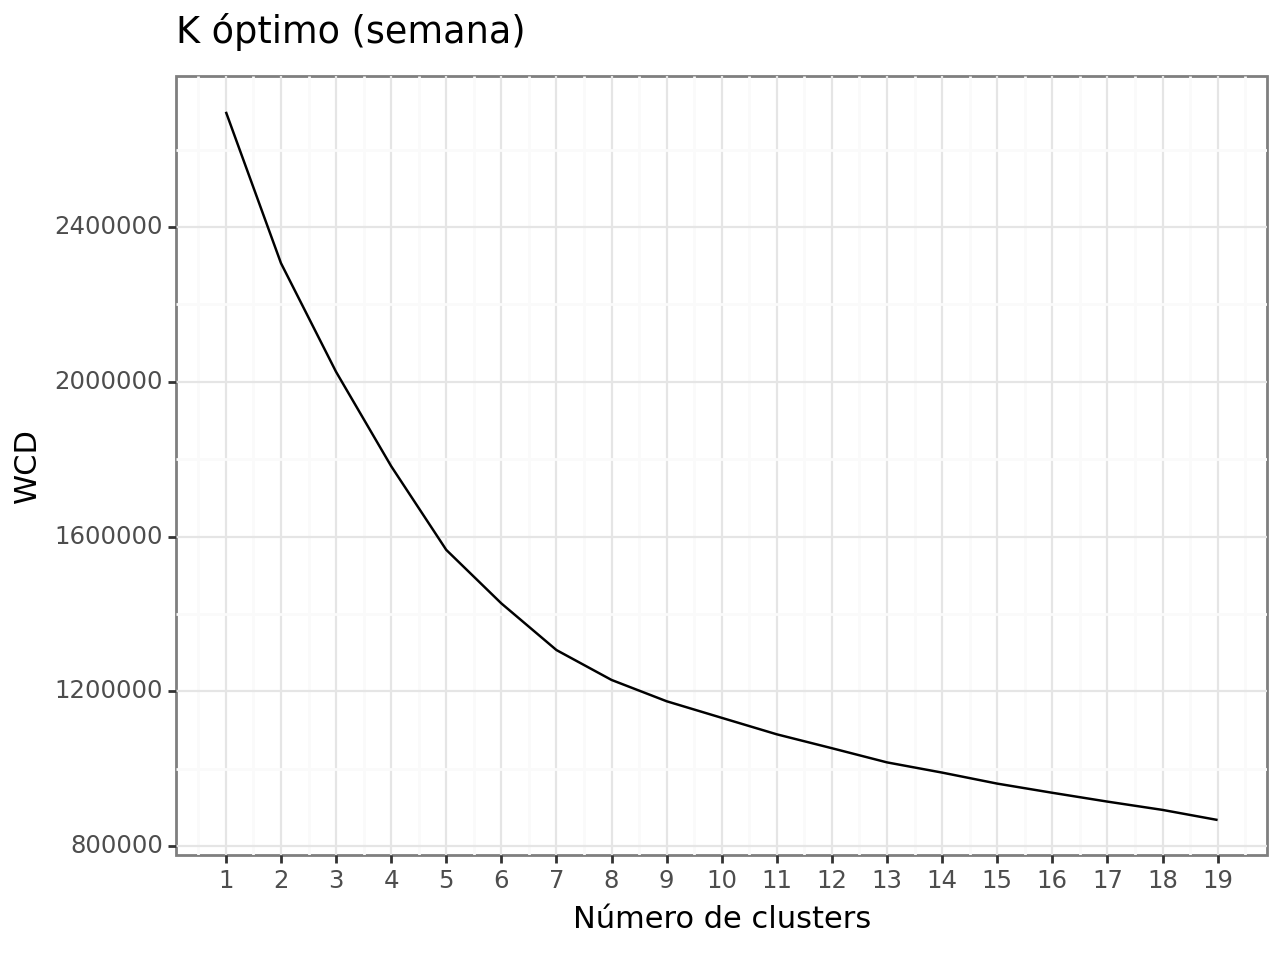

<Figure Size: (640 x 480)>

In [104]:
sse = []
numK = 20
# Definimos las variables a considerar en la clusterización:
features = df_semana_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]
for k in range(1, numK):
    kmeans = KMeans(n_clusters=k,n_init=10)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)
print(sse)

tempDataFrame = pd.DataFrame(range(1, numK), columns=["numK"])
tempDataFrame["sse"] = sse

(ggplot(tempDataFrame)+aes(x="numK", y="sse")+theme_bw()+geom_line()+labs(x = "Número de clusters", y = "WCD")
 +scale_x_continuous(breaks=range(1,numK))+ggtitle("K óptimo (semana)"))

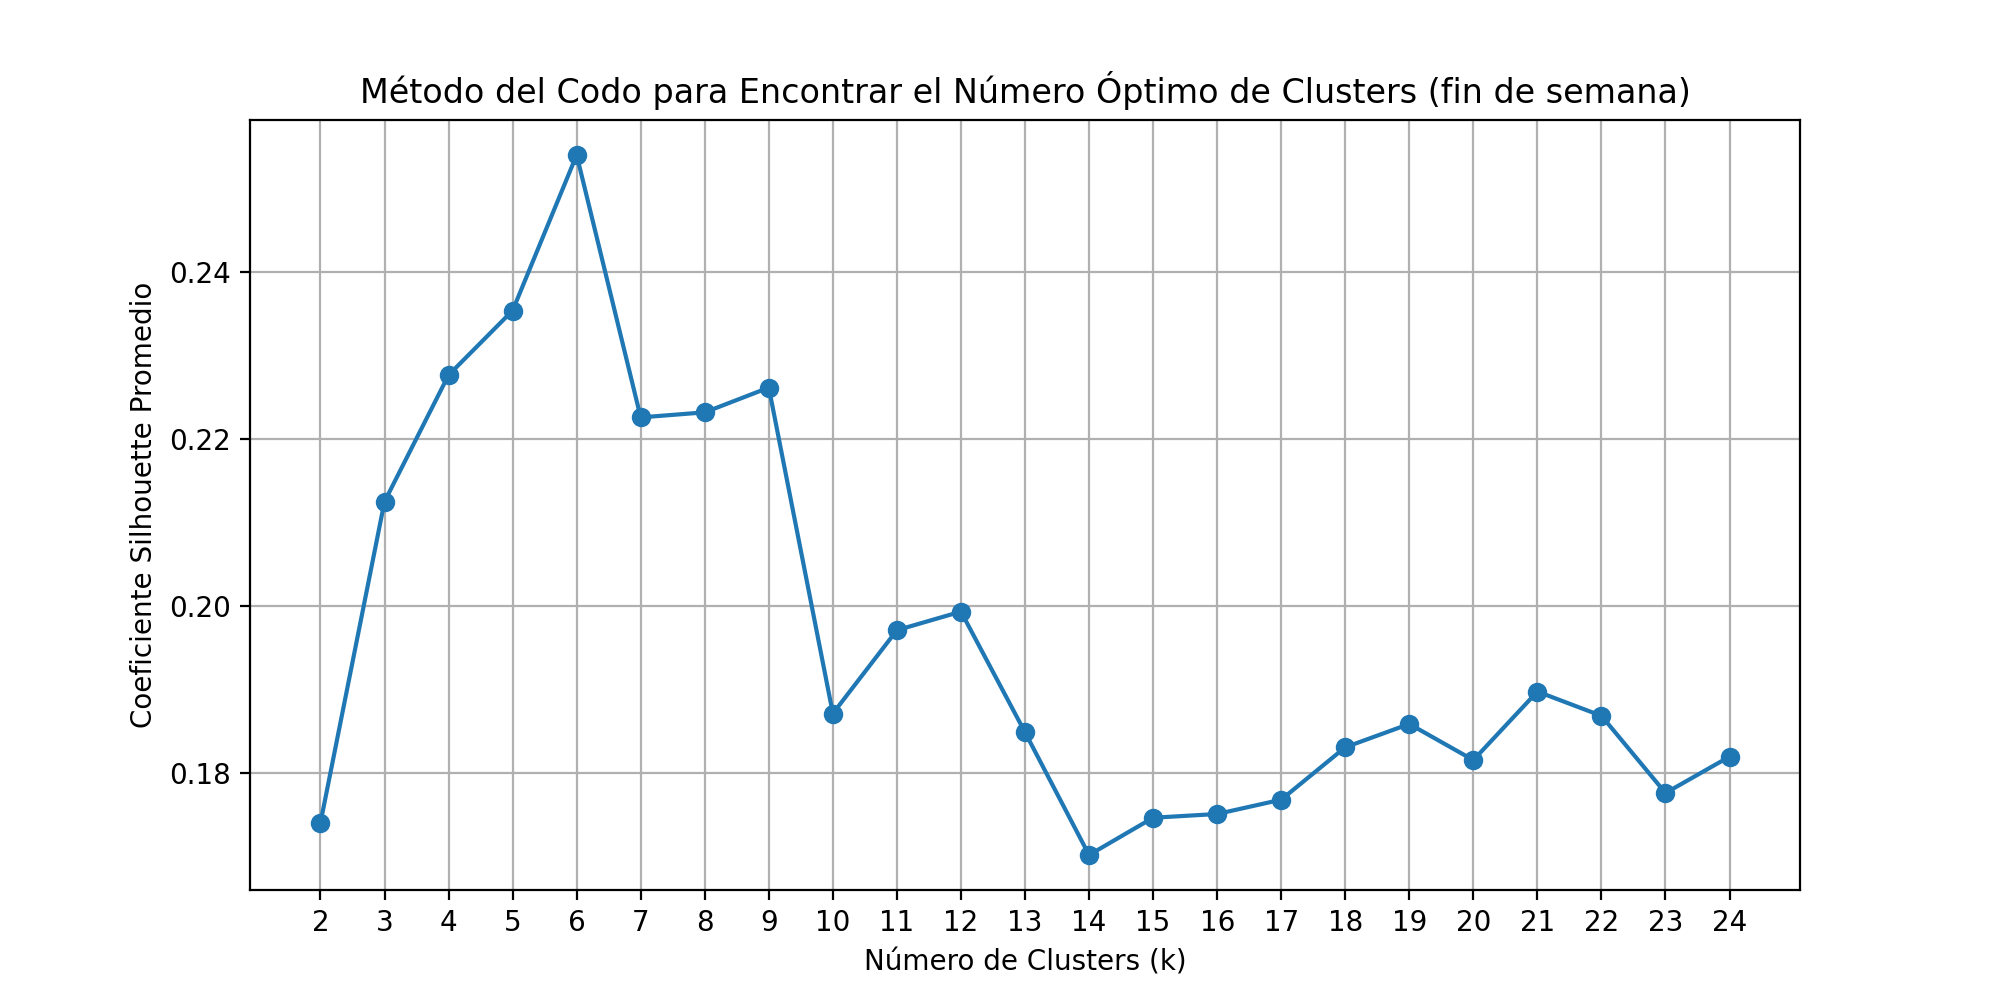

In [67]:
# Semana (se nos olvidó cambiar el título y demora más de 6 horas en correr, por lo que no lo actualizamos)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Datos de ejemplo (reemplaza esto con tus datos)
data_sil = df_semana_est.copy()[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]

# Rango de valores de k que deseas probar
k_values = range(2, 25)  

# Lista para almacenar los valores de silueta
silhouette_scores_sil = []

# Calcula el coeficiente de silueta para cada valor de k
for k in k_values:
    kmeans_sil = KMeans(n_clusters=k, random_state=0, n_init=5)
    cluster_labels_sil = kmeans_sil.fit_predict(data_sil)
    silhouette_avg_sil = silhouette_score(data_sil, cluster_labels_sil)
    silhouette_scores_sil.append(silhouette_avg_sil)

# Grafica los resultados
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores_sil, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente Silhouette Promedio')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters (fin de semana)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

- WCD: sugiere un k entre 7 y 9
- Silhouette: sugiere un k entre 6 y 9
- **Elección:** k=7

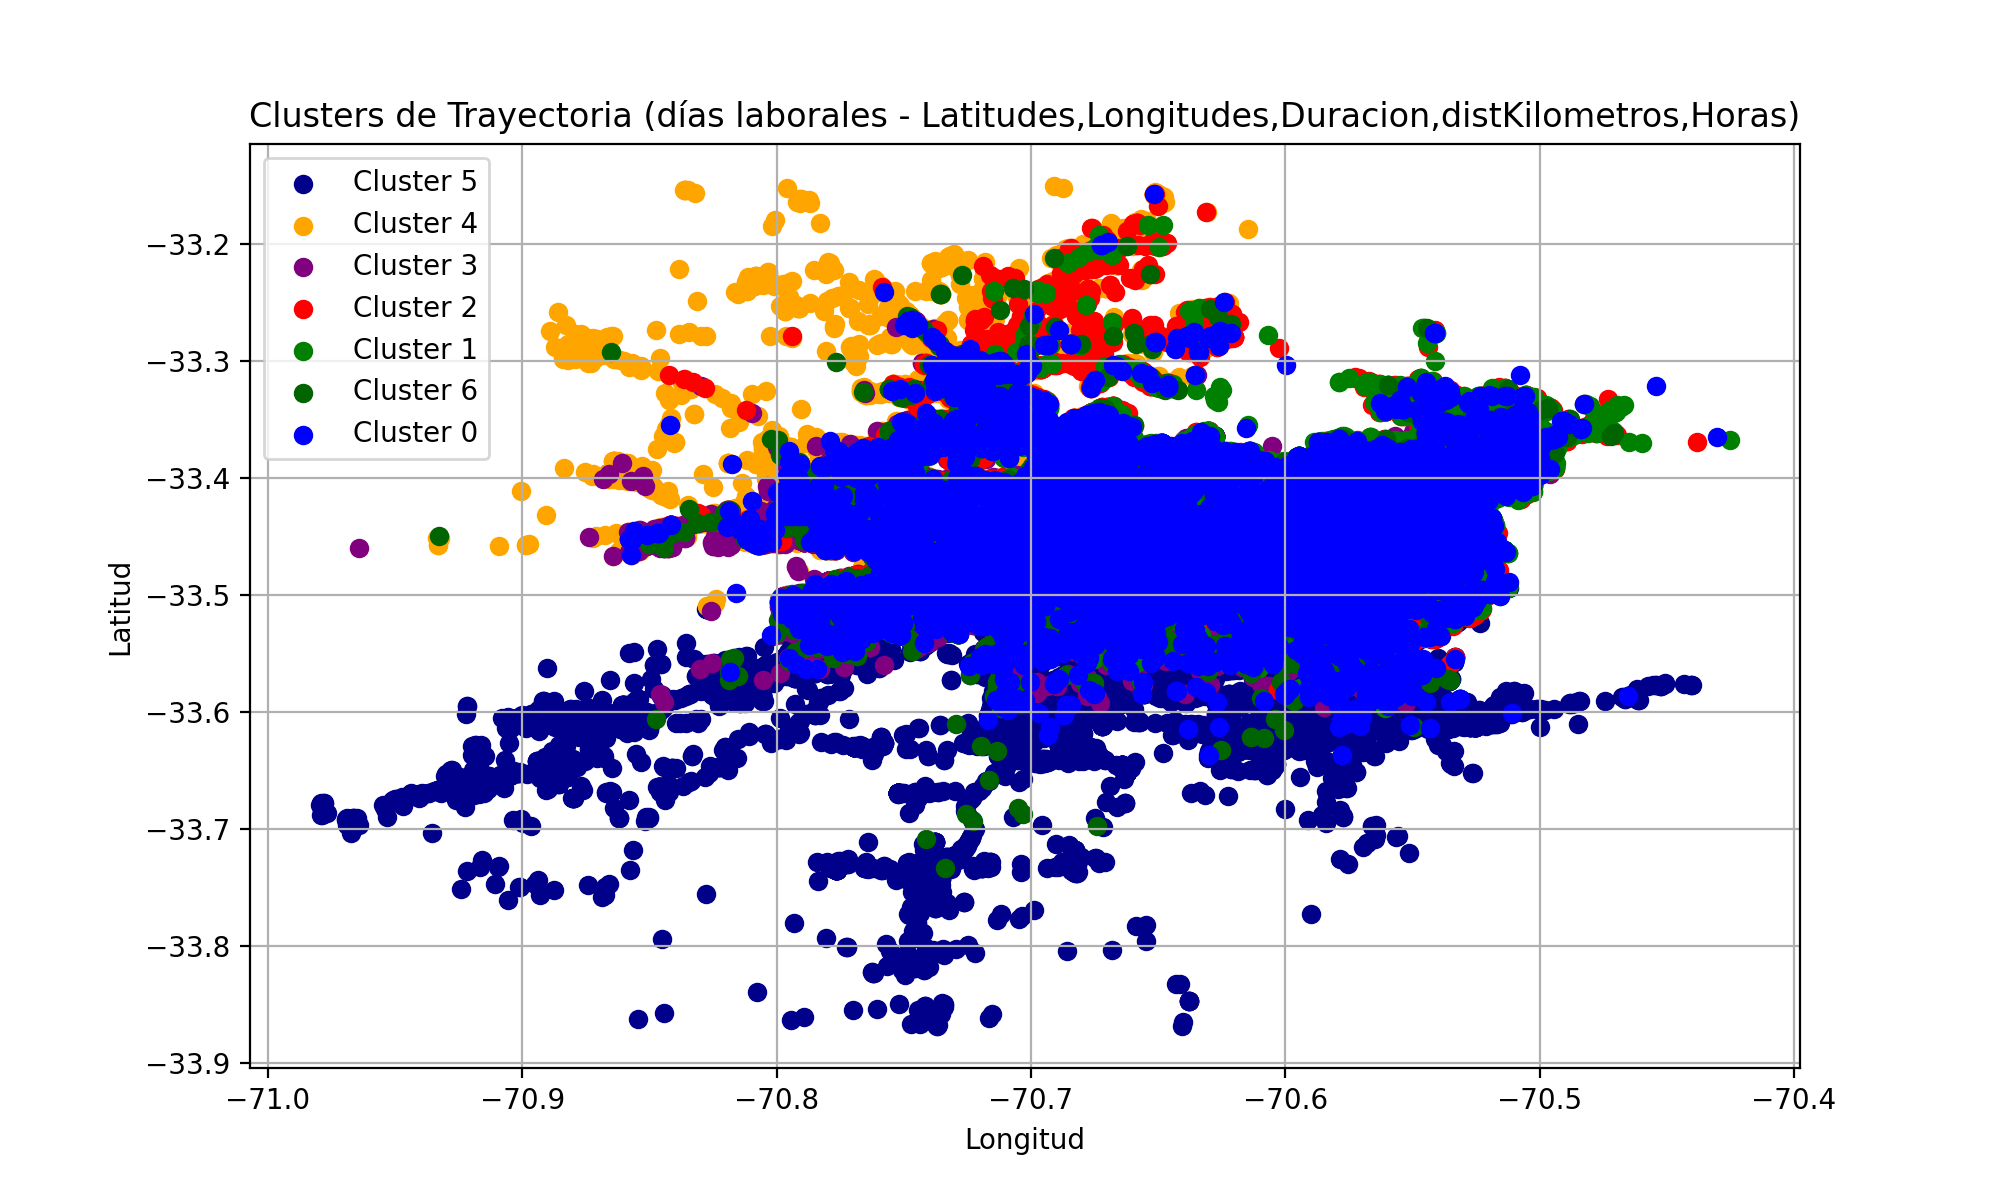

In [18]:
from sklearn.cluster import KMeans

features = df_semana_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]

# Aplicar K-Means a los datos de días laborales estandarizados (df_semana_est)
kmeans = KMeans(n_clusters=7, random_state=0, n_init=5)
clusters_semana = kmeans.fit_predict(features)

# Agregar las etiquetas de clusters a la base df_semana 
df_semana_est['Cluster'] = clusters_semana
df_semana['Cluster'] = clusters_semana # Para seguir teniendo la informacion sin estandarizar + los clusters creados

# Para los clusters:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']

import matplotlib.pyplot as plt

# Visualizar los resultados en el espacio de latitud y longitud originales (sin estandarizar)
plt.figure(figsize=(10, 6))

for cluster in df_semana_est['Cluster'].unique():
    cluster_data = df_semana[df_semana_est['Cluster'] == cluster]
    plt.scatter(cluster_data['LongitudPAB'], cluster_data['LatitudPAB'], color=colors[cluster % len(colors)], label=f'Cluster {cluster}')

plt.title('Clusters de Trayectoria (días laborales - Latitudes,Longitudes,Duracion,distKilometros,Horas)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

Para poder comprender los clusters creados, vamos a marcar en un mapa de la región la ubicación promedio de donde comienzan los viajes en cada cluster (LongitudPAB y LatitudPAB) con una estrella, y la ubicación promedio de donde terminan los viajes (LongitudCOM y LatitudCOM) con un marcador sin ícono

In [19]:
import folium
from geopy.distance import great_circle
import numpy as np

# Función para calcular la dirección de la flecha
def calculate_arrow_direction(start_coord, end_coord):
    start_lat, start_lon = start_coord
    end_lat, end_lon = end_coord
    angle = np.arctan2(end_lat - start_lat, end_lon - start_lon)
    return angle

# Crea un mapa centrado en las coordenadas iniciales
mapa = folium.Map(location=[df_semana['LatitudPAB'].mean(), df_semana['LongitudPAB'].mean()], zoom_start=12)

# Definir colores únicos para cada cluster
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']

# Agrega marcadores y flechas para los puntos de inicio y fin de trayectoria por cluster
for i, cluster in enumerate(df_semana_est['Cluster'].unique()):
    cluster_data = df_semana[df_semana_est['Cluster'] == cluster]
    start_centroid = cluster_data[['LatitudPAB', 'LongitudPAB']].mean()
    end_centroid = cluster_data[['LatitudCOM', 'LongitudCOM']].mean()
    
    # Agrega marcadores 
    folium.Marker(location=[start_centroid['LatitudPAB'], start_centroid['LongitudPAB']],
                  icon=folium.Icon(color=colors[cluster % len(colors)], icon='star'),
                  popup=f'Inicio Cluster {cluster}').add_to(mapa)
    
    folium.Marker(location=[end_centroid['LatitudCOM'], end_centroid['LongitudCOM']],
                  icon=folium.Icon(color=colors[cluster % len(colors)], icon='none'),
                  popup=f'Fin Cluster {cluster}').add_to(mapa)
    
    # Calcula la distancia entre los puntos de inicio y fin
    distance = great_circle([start_centroid['LatitudPAB'], start_centroid['LongitudPAB']],
                            [end_centroid['LatitudCOM'], end_centroid['LongitudCOM']]).meters
    
    # Crea una PolyLine con una flecha para representar la trayectoria con el color del cluster
    folium.PolyLine(locations=[(start_centroid['LatitudPAB'], start_centroid['LongitudPAB']),
                               (end_centroid['LatitudCOM'], end_centroid['LongitudCOM'])],
                    color=colors[cluster % len(colors)],
                    weight=2,
                    opacity=0.7,
                    popup=f'Distancia: {distance:.2f} metros').add_to(mapa)

# Agrega etiquetas de colores en una esquina del mapa
for i, cluster in enumerate(df_semana_est['Cluster'].unique()):
    mapa.get_root().html.add_child(folium.Element(f'<div style="background-color: {colors[cluster % len(colors)]}; color: white; padding: 5px;">Cluster {cluster}</div>'))

# Muestra el mapa interactivo
mapa

# Fin de semana

Ver k óptimo para fin de semana:

[380030.0000000001, 324043.9553656873, 278166.01141804684, 243120.51459434064, 221007.02540205827, 205975.82979768526, 193399.23863604138, 181260.39828471182, 173410.8184276077, 165535.75383196236, 159023.43693973086, 152737.51501671944, 147880.35342635593, 143653.47050578904, 139560.97653528862, 136036.28037414182, 132273.5028162296, 130575.09023643204, 126690.11311118616]


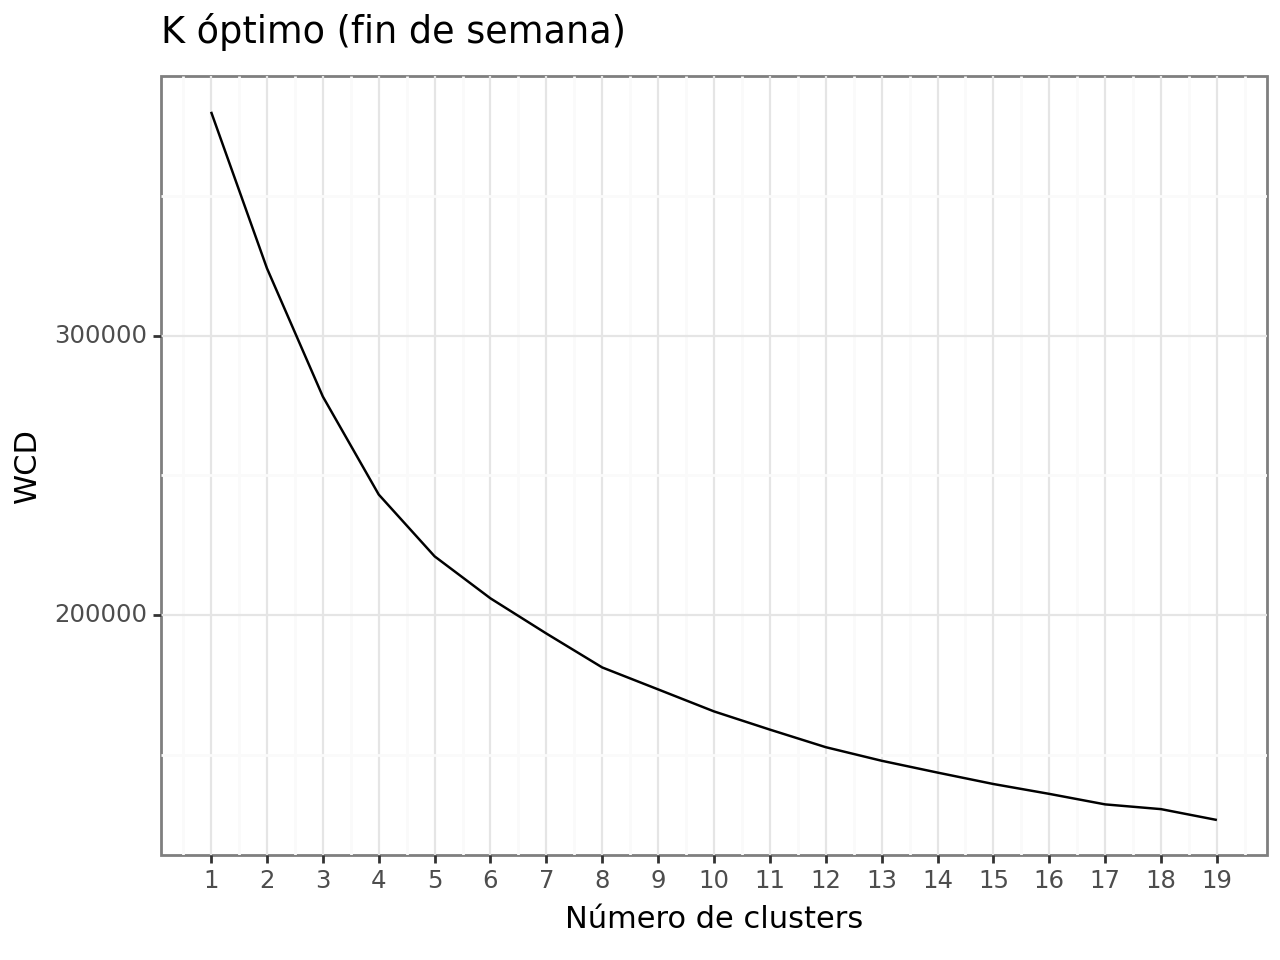

<Figure Size: (640 x 480)>

In [20]:
sse_ = []
numK_ = 20
features_ = df_finde_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]
for k in range(1, numK_):
    kmeans_ = KMeans(n_clusters=k,n_init=10)
    kmeans_.fit(features_)
    sse_.append(kmeans_.inertia_)
print(sse_)

tempDataFrame_ = pd.DataFrame(range(1, numK_), columns=["numK_"])
tempDataFrame_["sse_"] = sse_

(ggplot(tempDataFrame_)+aes(x='numK_', y='sse_')+theme_bw()+geom_line()+labs(x = "Número de clusters", y = "WCD")
 +scale_x_continuous(breaks=range(1,numK_))+ggtitle("K óptimo (fin de semana)"))

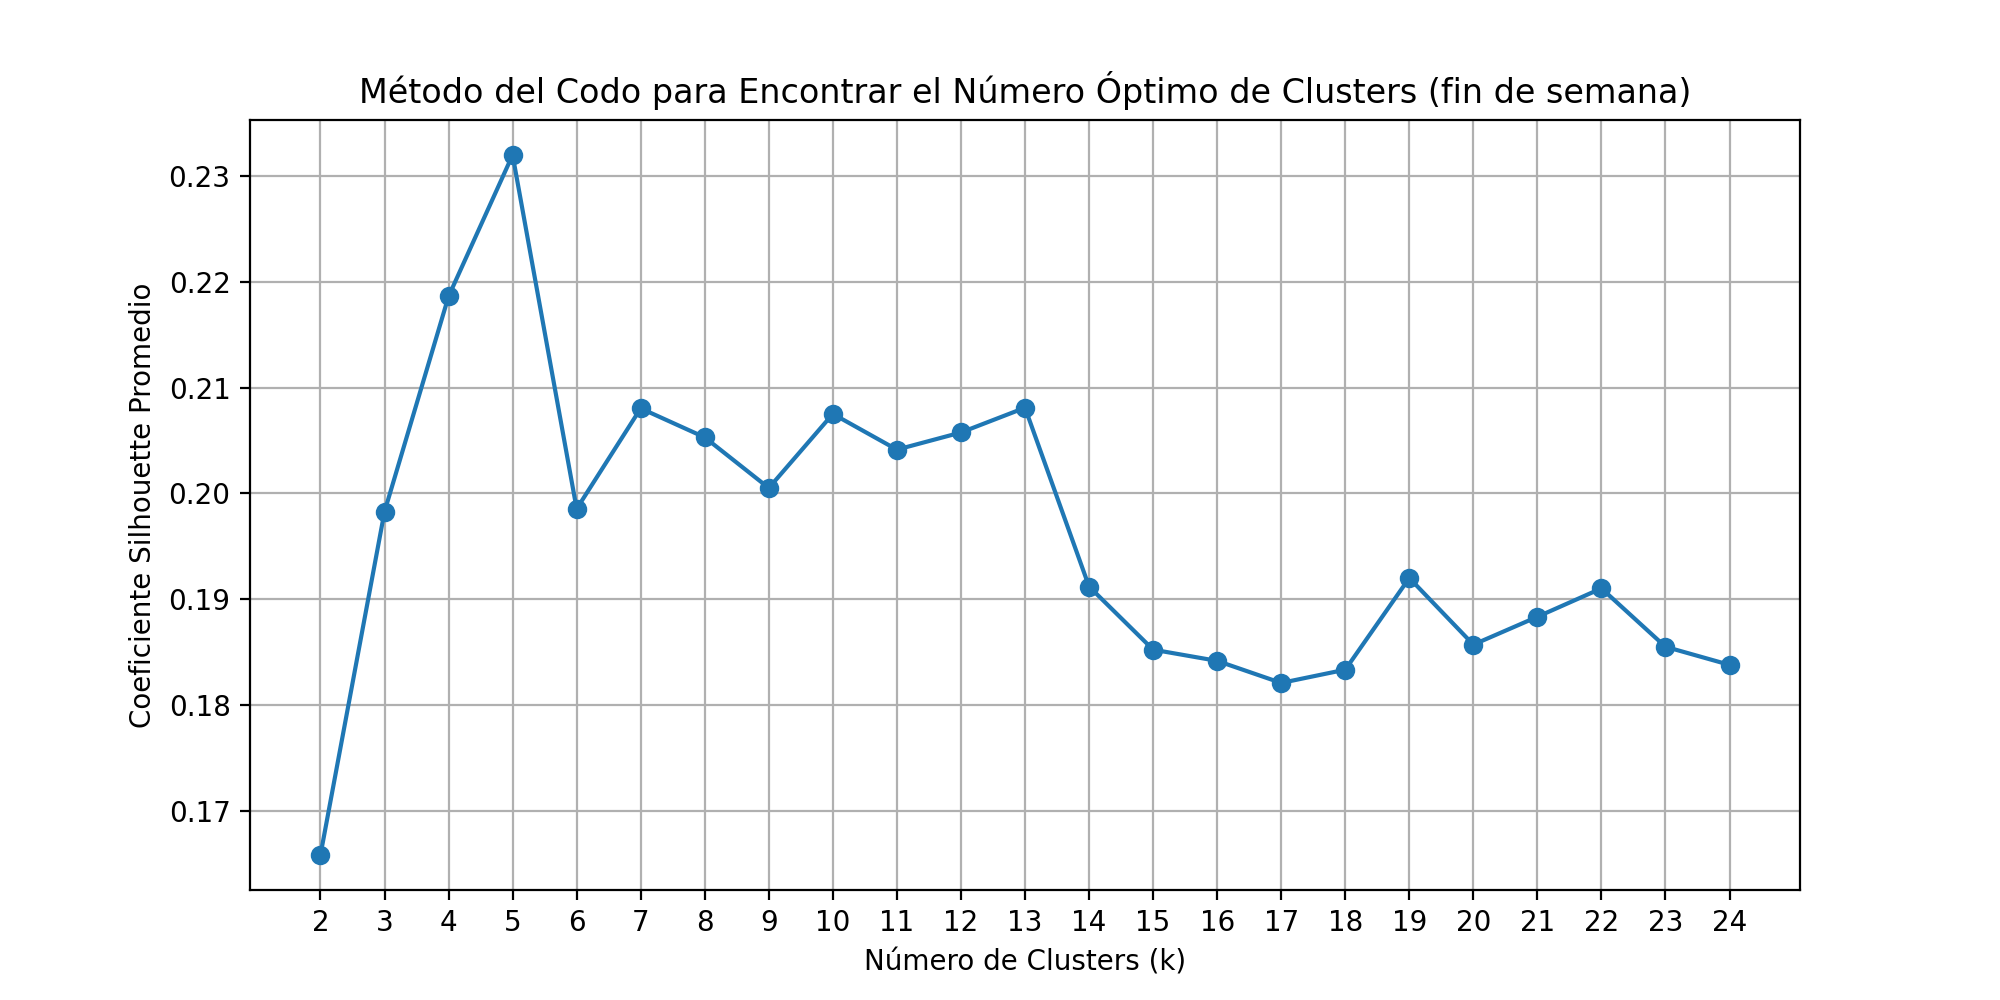

In [249]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Datos de ejemplo (reemplaza esto con tus datos)
data = df_finde_est.copy()[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]

# Rango de valores de k que deseas probar
k_values = range(2, 25)  

# Lista para almacenar los valores de silueta
silhouette_scores_sil_ = []

# Calcula el coeficiente de silueta para cada valor de k
for k in k_values:
    kmeans_sil_ = KMeans(n_clusters=k, random_state=0, n_init=5)
    cluster_labels_sil_ = kmeans_sil_.fit_predict(data)
    silhouette_avg_sil_ = silhouette_score(data, cluster_labels_sil_)
    silhouette_scores_sil_.append(silhouette_avg_sil_)

# Grafica los resultados
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores_sil_, marker='o', linestyle='-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente Silhouette Promedio')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters (fin de semana)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

- WCD: sugiere k entre 5 y 8
- Silhouette: sugiere k entre 5 y 13 
- **Elección:** k=6

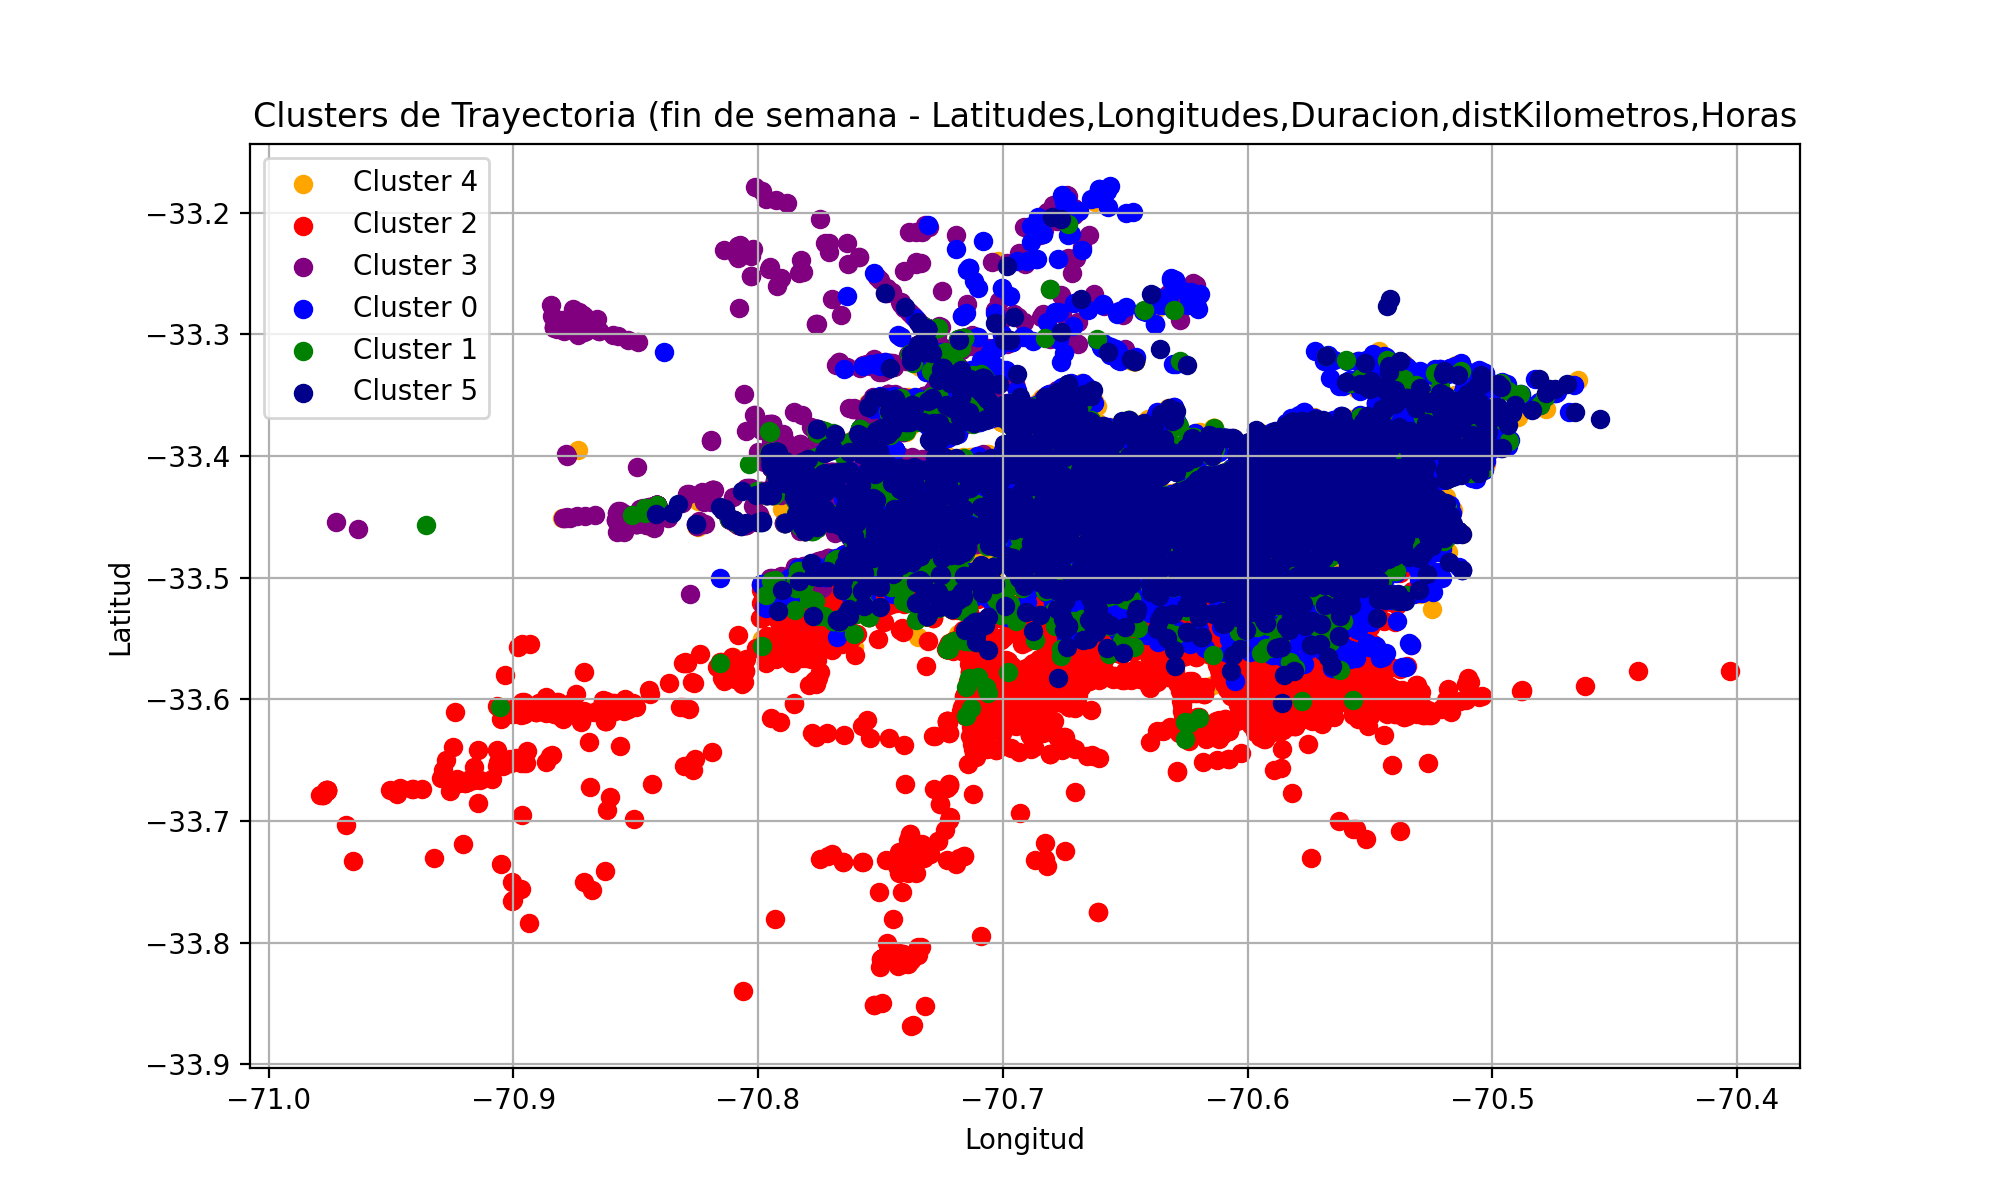

In [21]:
from sklearn.cluster import KMeans

features_1 = df_finde_est[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]

# Aplicar K-Means a los datos estandarizados (df_finde_est)
kmeans_1 = KMeans(n_clusters=6, random_state=0, n_init=10)
clusters_finde_1 = kmeans_1.fit_predict(features_1)

# Agregar las etiquetas de clusters a df_semana
df_finde_est['Cluster'] = clusters_finde_1
df_finde['Cluster'] = clusters_finde_1

# Para los clusters:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']

import matplotlib.pyplot as plt

# Visualizar los resultados en el espacio de latitud y longitud originales (sin estandarizar)
plt.figure(figsize=(10, 6))

for cluster_1 in df_finde_est['Cluster'].unique():
    cluster_data_1 = df_finde[df_finde_est['Cluster'] == cluster_1]
    plt.scatter(cluster_data_1['LongitudPAB'], cluster_data_1['LatitudPAB'], color=colors[cluster_1 % len(colors)], label=f'Cluster {cluster_1}')

plt.title('Clusters de Trayectoria (fin de semana - Latitudes,Longitudes,Duracion,distKilometros,Horas')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import folium
from geopy.distance import great_circle
import numpy as np

# Crea un mapa centrado en las coordenadas iniciales
mapa_finde = folium.Map(location=[df_finde['LatitudPAB'].mean(), df_finde['LongitudPAB'].mean()], zoom_start=12)

colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']

# Agrega marcadores y flechas para los puntos de inicio y fin de trayectoria por cluster
for i, cluster in enumerate(df_finde_est['Cluster'].unique()):
    cluster_data_finde = df_finde[df_finde_est['Cluster'] == cluster]
    start_centroid_finde = cluster_data_finde[['LatitudPAB', 'LongitudPAB']].mean()
    end_centroid_finde = cluster_data_finde[['LatitudCOM', 'LongitudCOM']].mean()

    # Agrega marcadores 
    folium.Marker(location=[start_centroid_finde['LatitudPAB'], start_centroid_finde['LongitudPAB']],
                  icon=folium.Icon(color=colors[cluster % len(colors)], icon='star'),
                  popup=f'Inicio Cluster {cluster}').add_to(mapa_finde)
    
    folium.Marker(location=[end_centroid_finde['LatitudCOM'], end_centroid_finde['LongitudCOM']],
                  icon=folium.Icon(color=colors[cluster % len(colors)], icon='none'),
                  popup=f'Fin Cluster {cluster}').add_to(mapa_finde)
    
    
    # Crea una PolyLine con una flecha para representar la trayectoria con el color del cluster
    folium.PolyLine(locations=[(start_centroid_finde['LatitudPAB'], start_centroid_finde['LongitudPAB']),
                               (end_centroid_finde['LatitudCOM'], end_centroid_finde['LongitudCOM'])],
                    color=colors[cluster % len(colors)],
                    weight=2,
                    opacity=0.7,
                    popup=f'Distancia: {distance:.2f} metros').add_to(mapa_finde)

# Agrega etiquetas de colores en una esquina del mapa
for i, cluster in enumerate(df_finde_est['Cluster'].unique()):
    mapa_finde.get_root().html.add_child(folium.Element(f'<div style="background-color: {colors[cluster % len(colors)]}; color: white; padding: 5px;">Cluster {cluster}</div>'))

# Muestra el mapa interactivo
mapa_finde

# Pregunta 3: Interpretar los clusters obtenidos

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analisis_clusters(df, kmeans, var_to_analyze, df_name, cluster_colors):
    cluster_stats = pd.DataFrame(np.zeros((kmeans.n_clusters, 2)), columns=["mean", "std"])

    # Calcular el promedio y la desviación estándar de la variable para cada cluster
    for i in range(kmeans.n_clusters):
        cluster_data = df[df['Cluster'] == i]
        cluster_stats.loc[i, 'mean'] = cluster_data[var_to_analyze].mean()
        cluster_stats.loc[i, 'std'] = cluster_data[var_to_analyze].std()

    plt.figure(figsize=(10, 6))

    for i, row in cluster_stats.iterrows():
        color = cluster_colors[i]  # Obtener el color del cluster desde la lista de colores
        plt.vlines(i, ymin=row['mean'] - row['std'], ymax=row['mean'] + row['std'], color=color, alpha=0.7, linewidth=2)
        plt.scatter(i, row['mean'], color=color, marker='o', s=100)
        plt.hlines(y=row['mean'] - row['std'], xmin=i - 0.1, xmax=i + 0.1, color=color, linestyle='-', linewidth=2)
        plt.hlines(y=row['mean'] + row['std'], xmin=i - 0.1, xmax=i + 0.1, color=color, linestyle='-', linewidth=2)

    plt.xticks(range(kmeans.n_clusters))
    plt.xlabel('Clusters')
    plt.ylabel(var_to_analyze)
    plt.title(f'Análisis de {var_to_analyze} por Cluster - Datos: {df_name}')
    plt.grid(True)
    plt.show()

Para visualizar los valores de las variables que no podemos ver en el mapa (Horas, Duracion, distKilometros) hacemos gráficos:

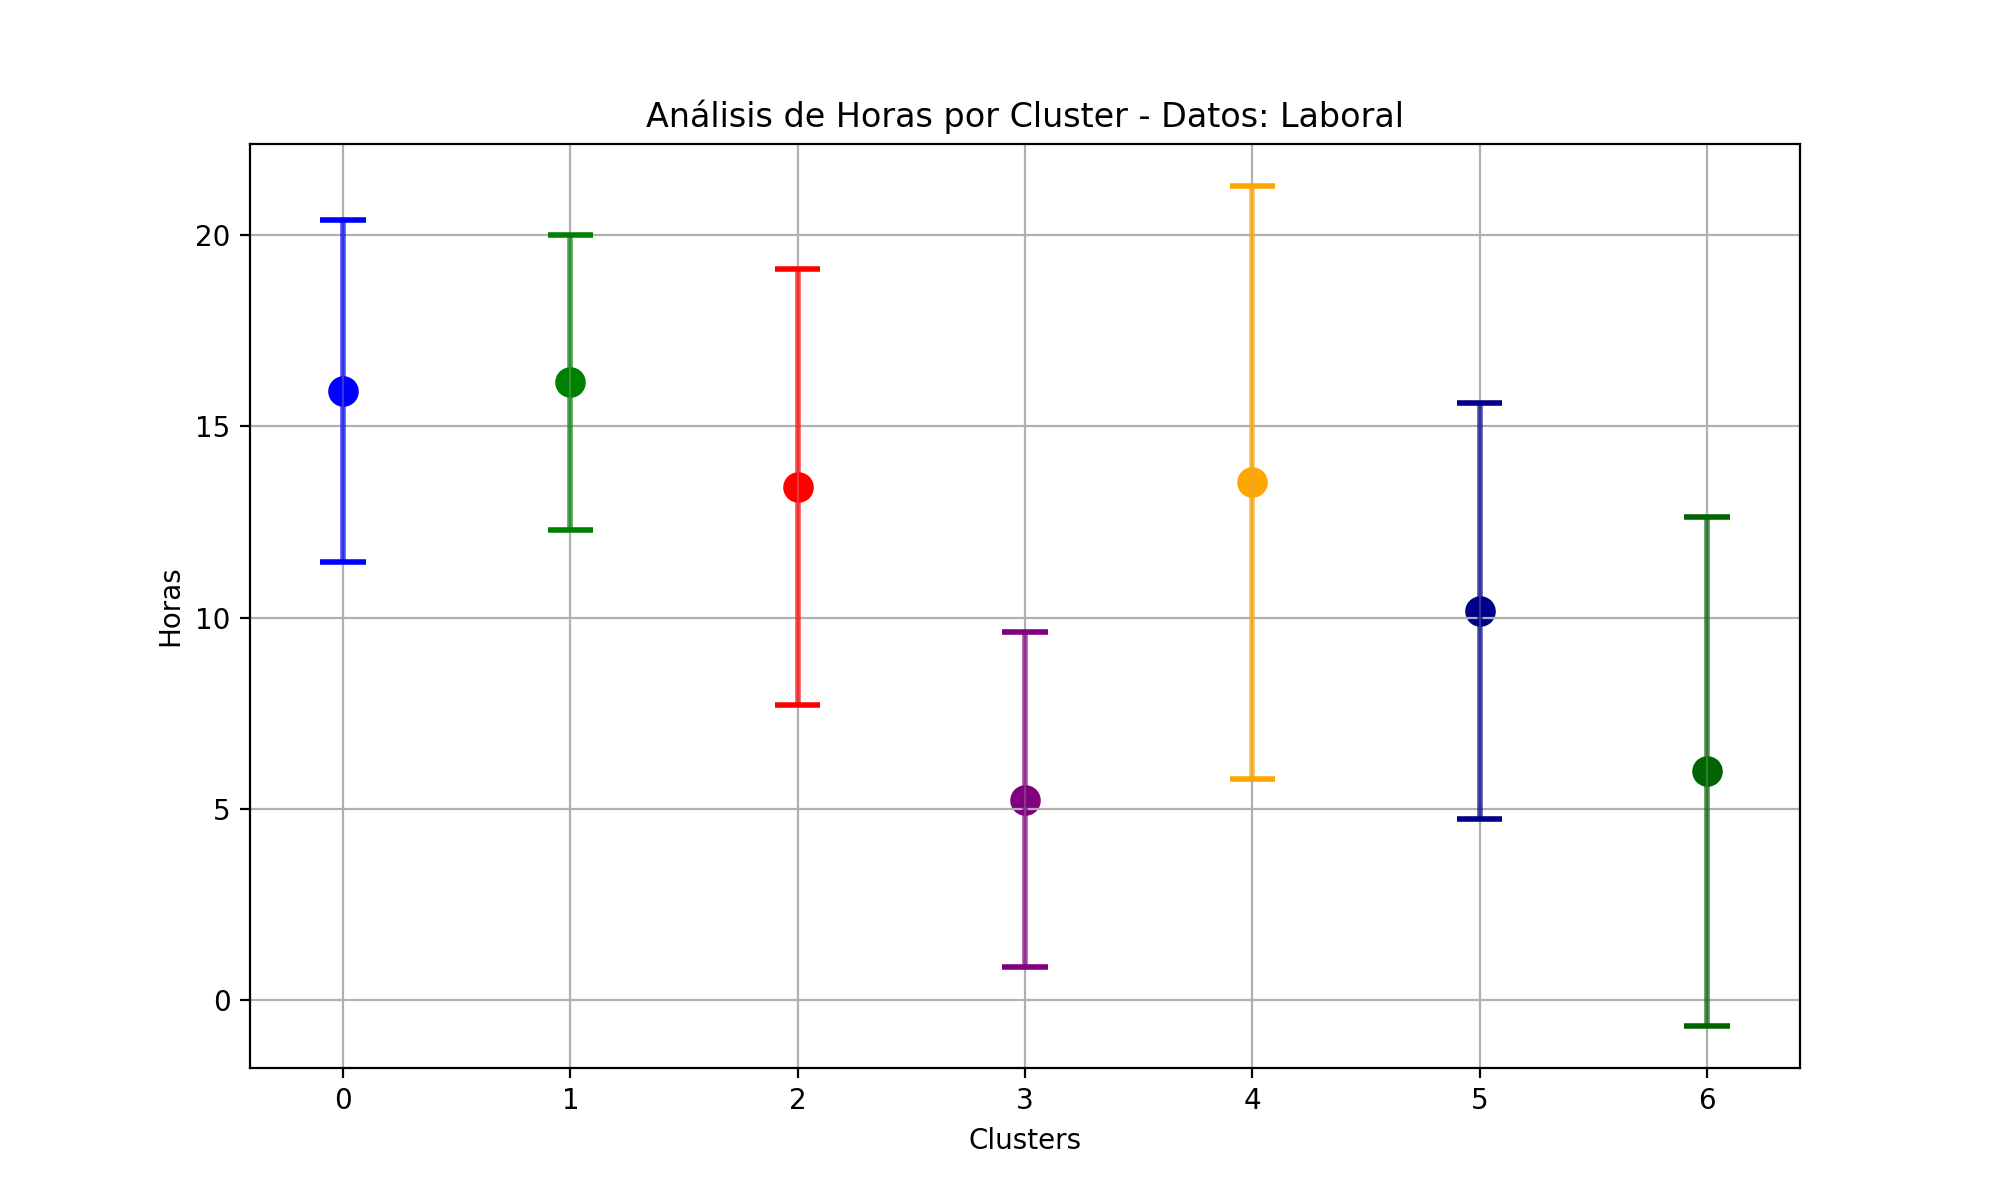

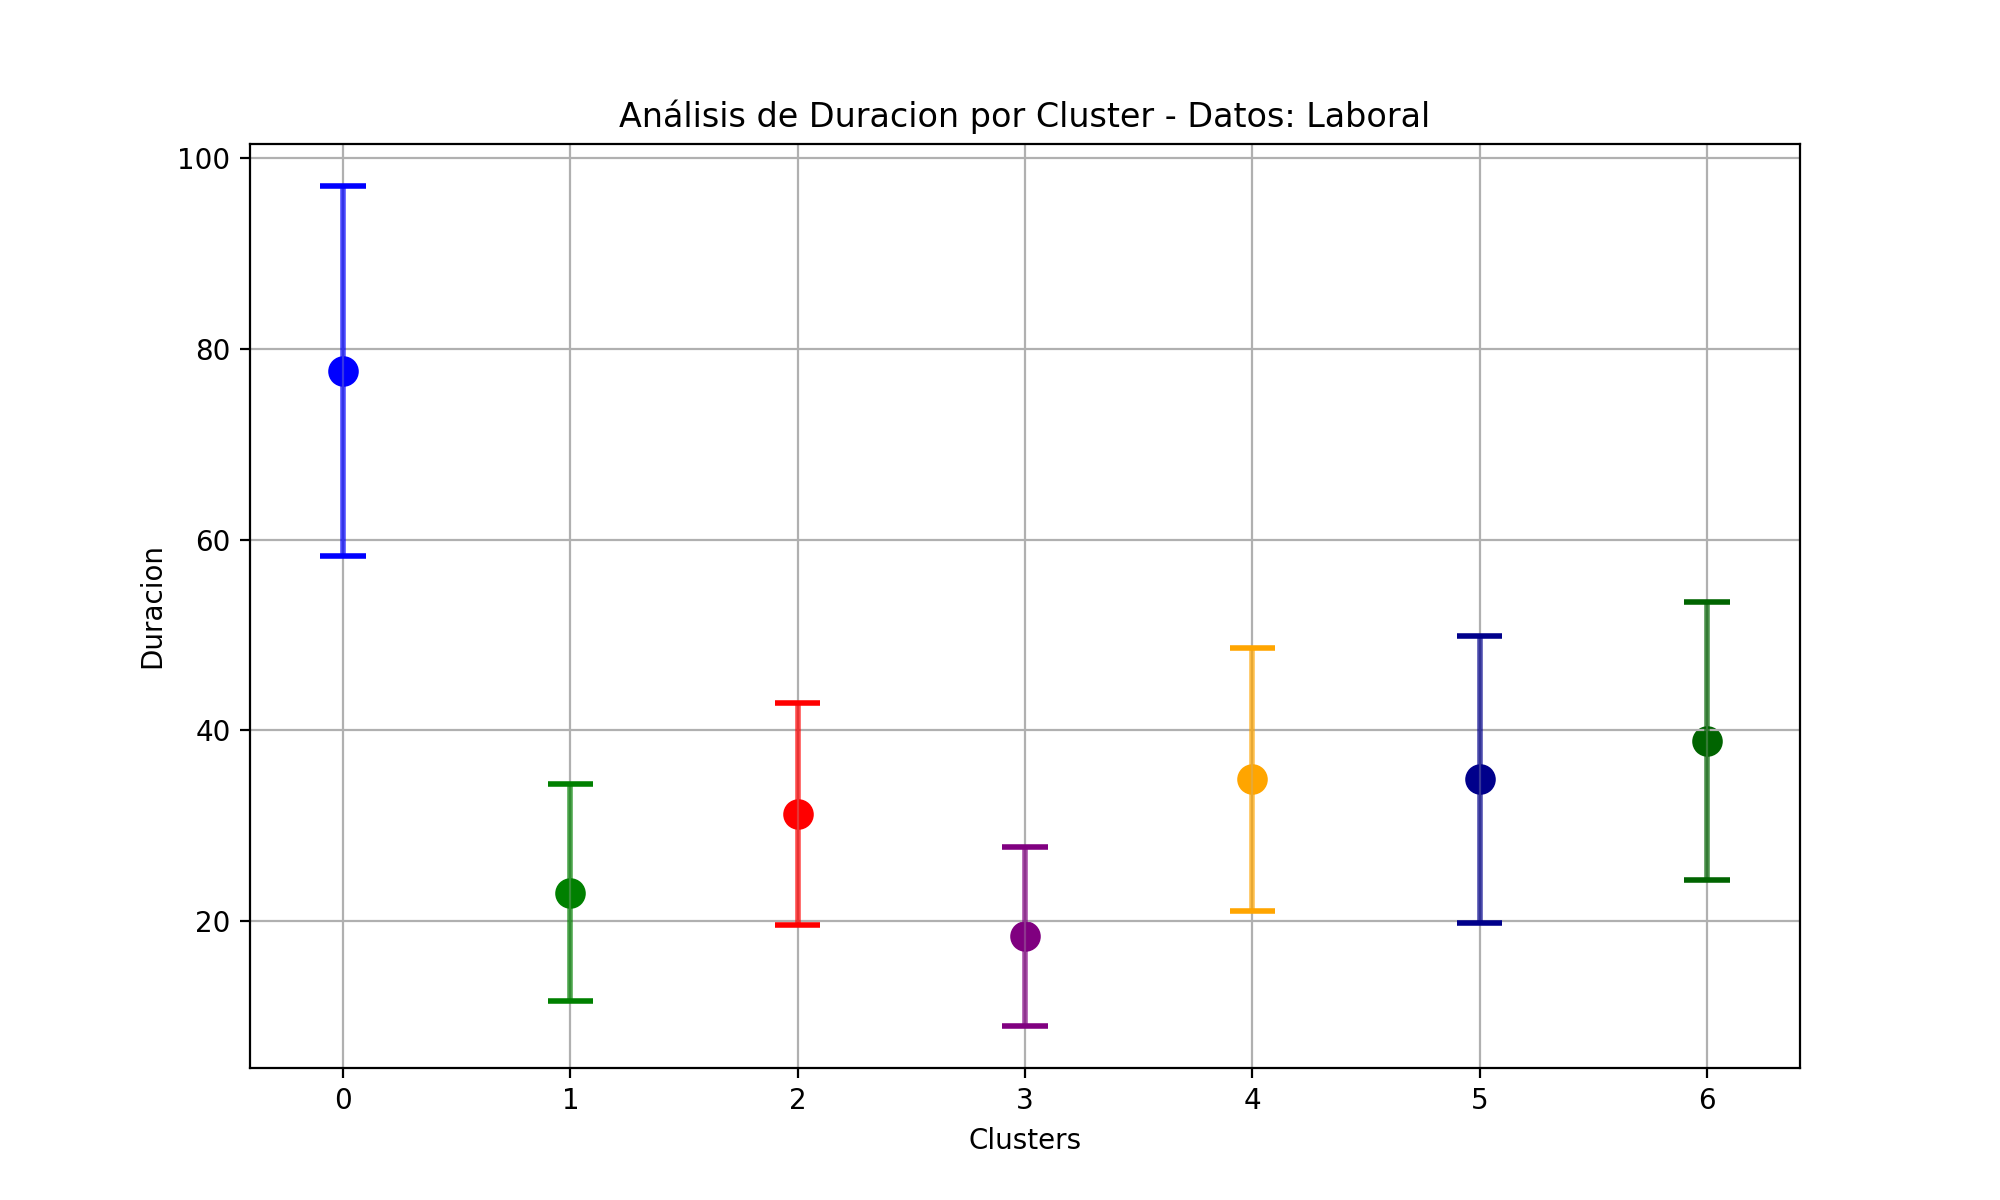

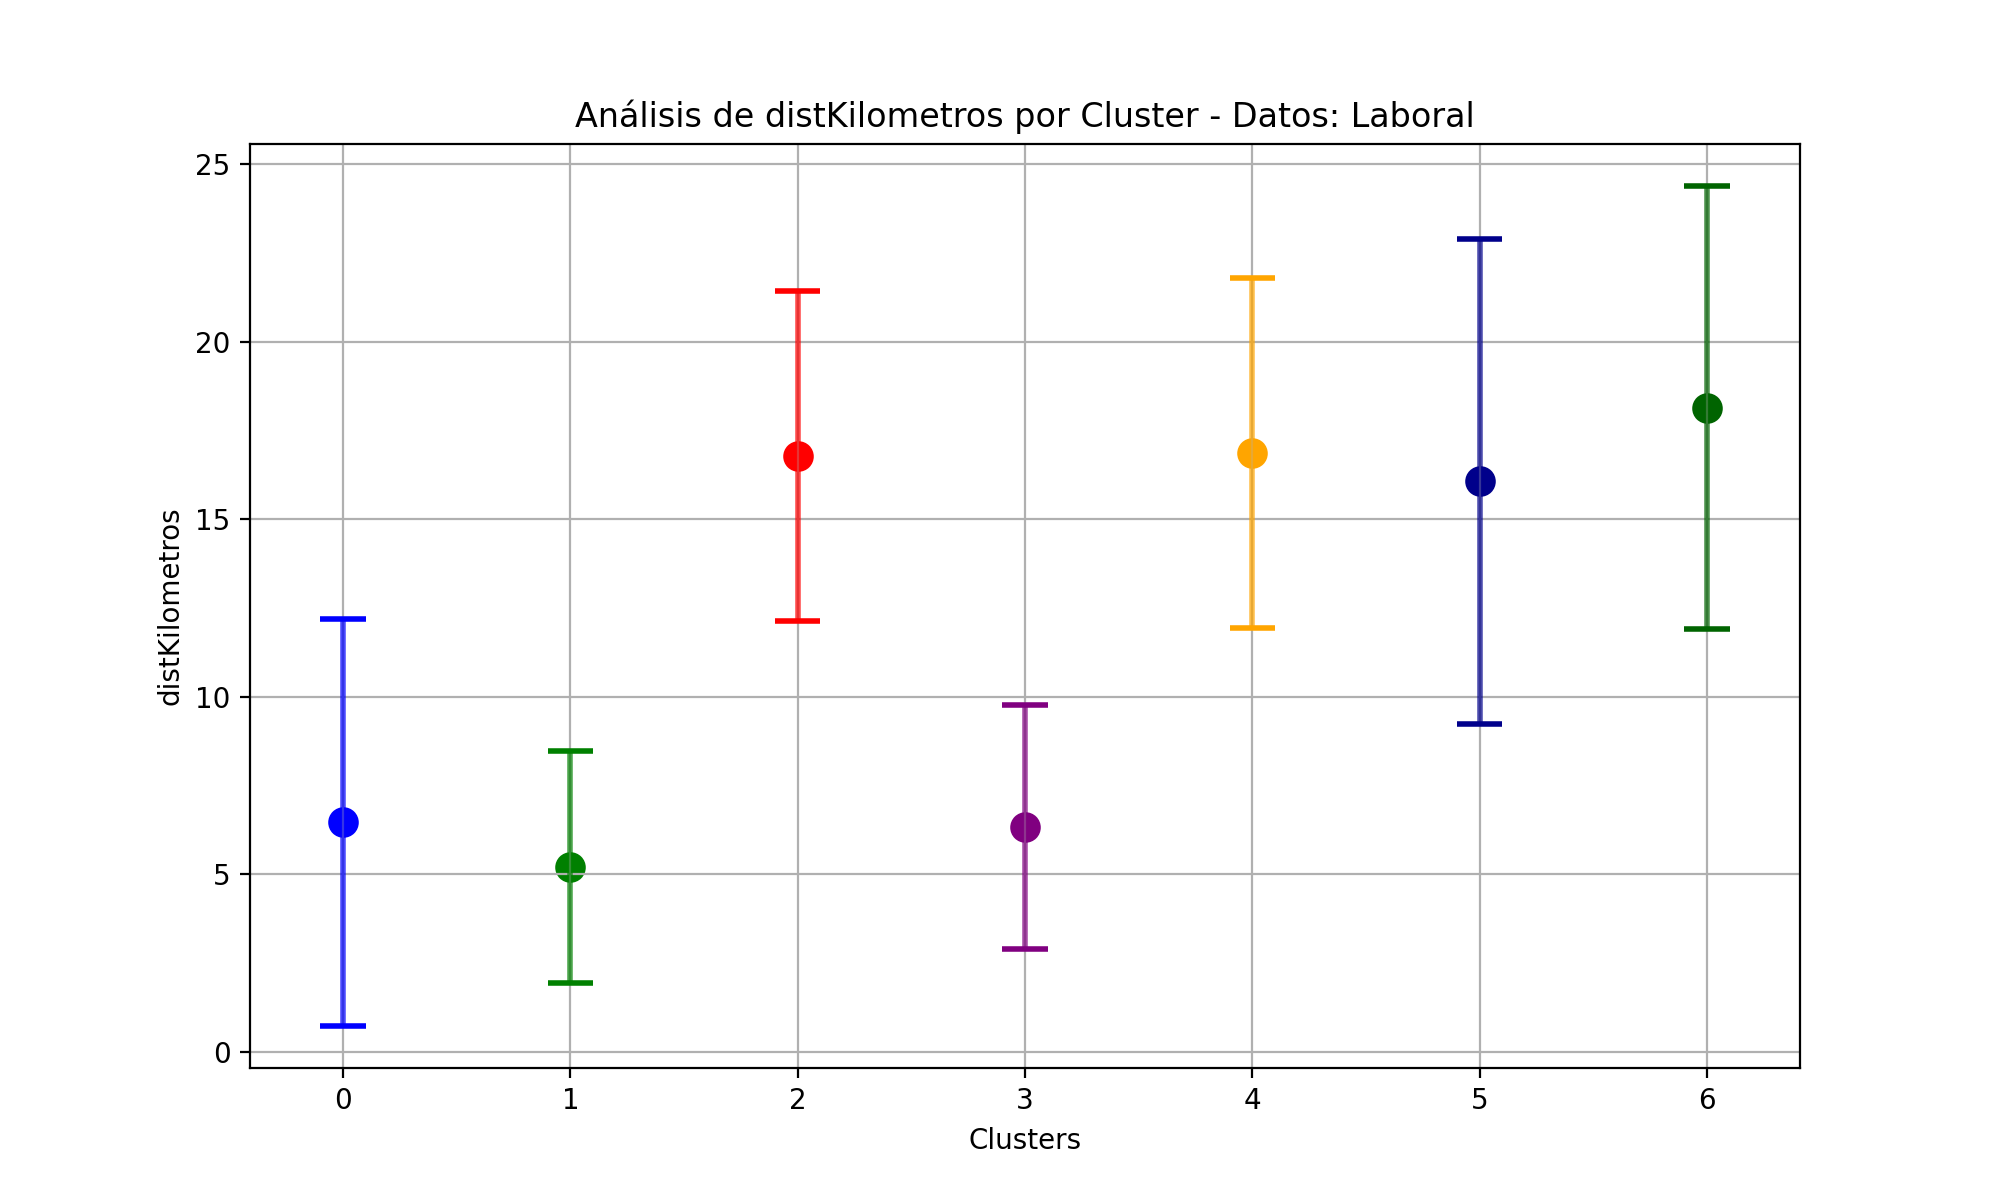

In [24]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']
analisis_clusters(df_semana, kmeans, 'Horas', 'Laboral', colors)
analisis_clusters(df_semana, kmeans, 'Duracion', 'Laboral', colors)
analisis_clusters(df_semana, kmeans, 'distKilometros', 'Laboral', colors)

Lo mismo para los datos de los días de fin de semana:

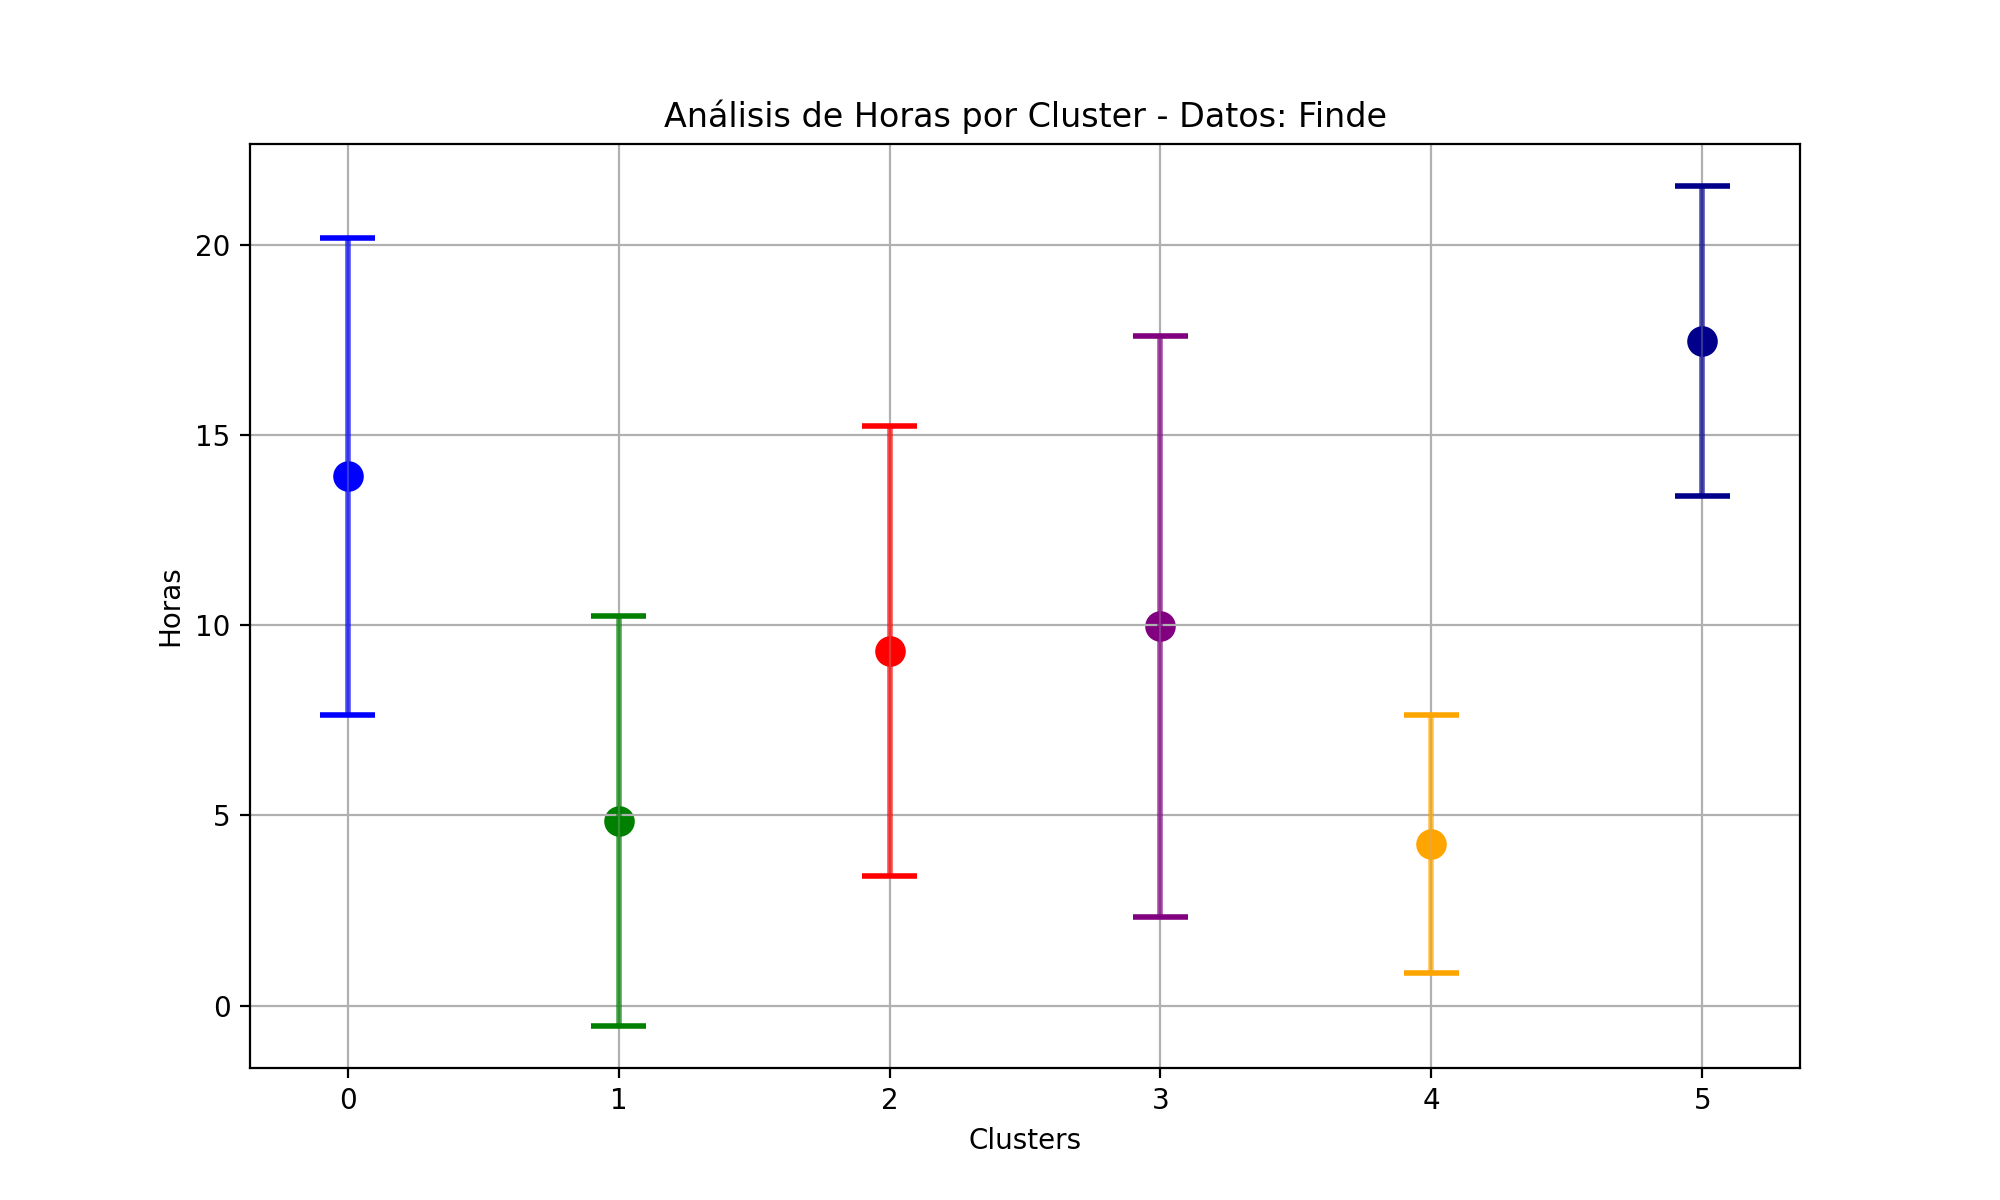

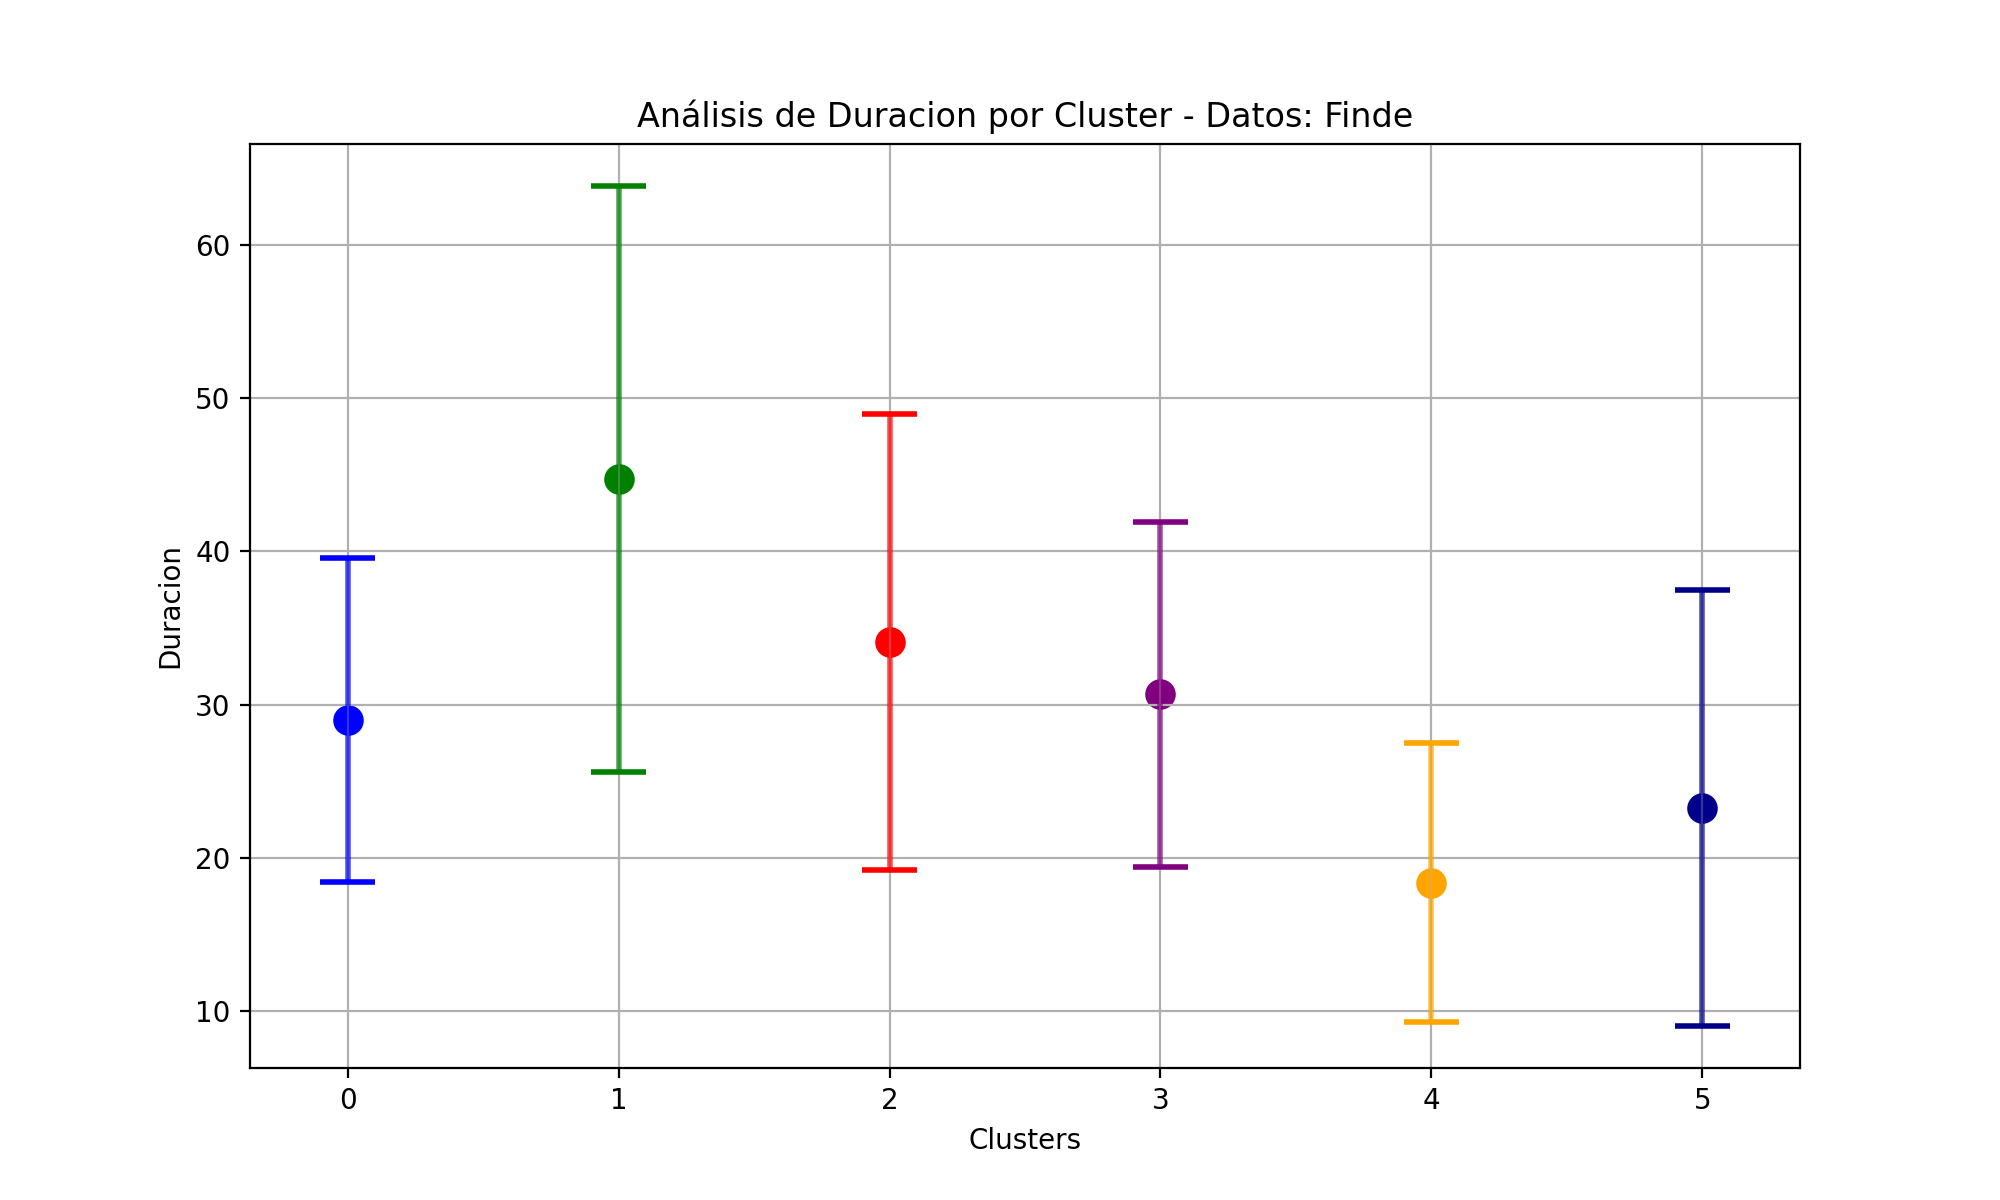

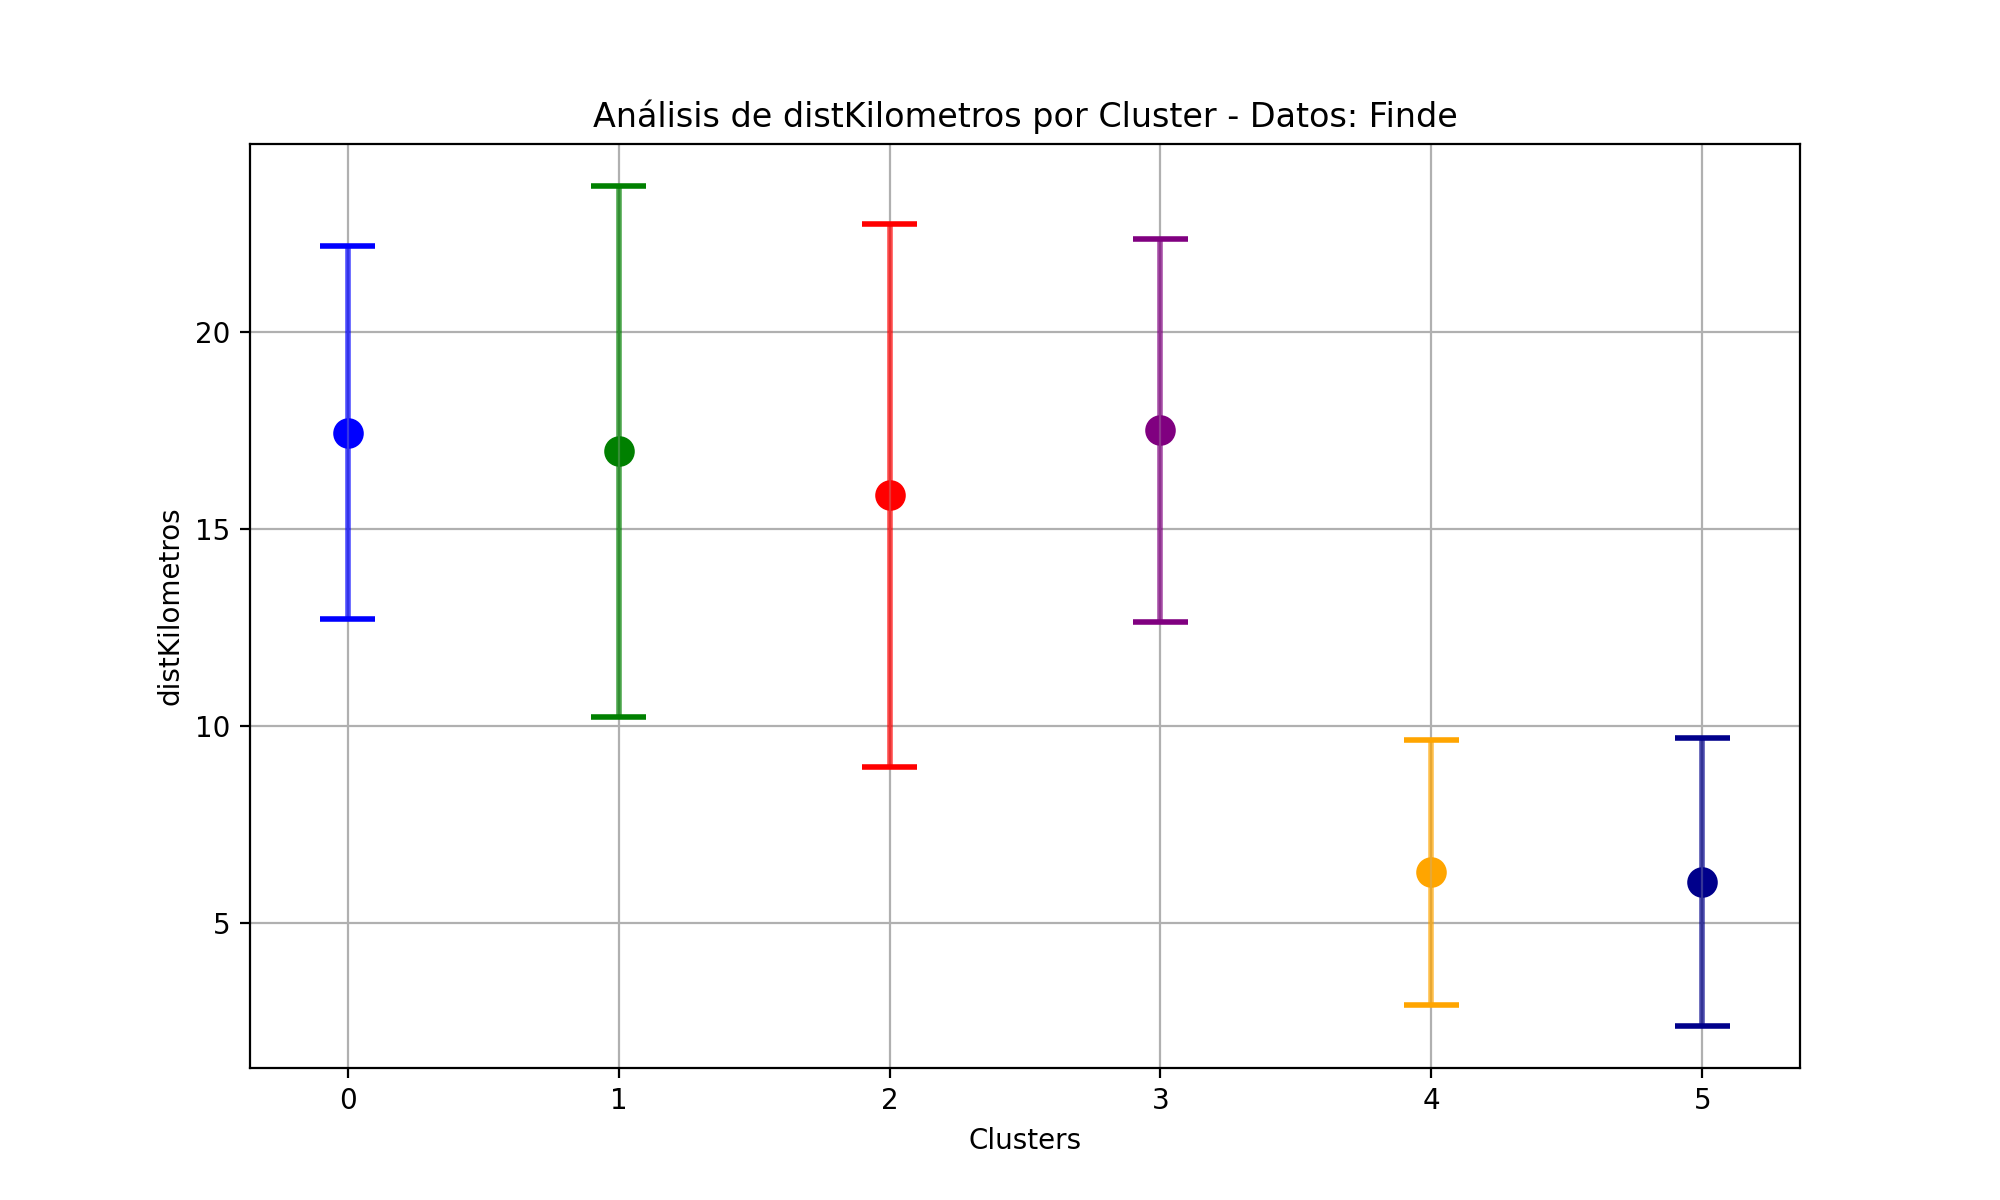

In [25]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'darkgreen', 'darkred', 'cadetblue', 'lightgreen', 'beige', 'pink', 'cyan', 'magenta', 'yellow']

analisis_clusters(df_finde, kmeans_1, 'Horas', 'Finde', colors)
analisis_clusters(df_finde, kmeans_1, 'Duracion', 'Finde', colors)
analisis_clusters(df_finde, kmeans_1, 'distKilometros', 'Finde', colors)

In [26]:
# Ver la cantidad de viajes por cluster
cantidad_viajes_por_cluster_semana = df_semana['Cluster'].value_counts().sort_index()
cantidad_viajes_por_cluster_finde = df_finde['Cluster'].value_counts().sort_index()

# Imprime el resultado
print('Día de semana:')
print(cantidad_viajes_por_cluster_semana)
print('Fin de semana:')
print(cantidad_viajes_por_cluster_finde)

Día de semana:
Cluster
0     28901
1    113472
2     55372
3     67175
4     49394
5     29387
6     32069
Name: count, dtype: int64
Fin de semana:
Cluster
0     8861
1     8075
2     5370
3     9166
4    16016
5     6802
Name: count, dtype: int64


# Pregunta 4: Modificar kmeans

Métricas de desempeño de los kmeans que tenemos:

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
coef_silhouette_semana = silhouette_score(features, kmeans.labels_, random_state=0)

In [29]:
coef_silhouette_finde = silhouette_score(features_, kmeans_1.labels_, random_state=0)

In [30]:
print(f'Coeficiente silhouette días de semana: {coef_silhouette_semana}')
print(f'Coeficiente silhouette fin de semana: {coef_silhouette_finde}')

Coeficiente silhouette días de semana: 0.22262419507340506
Coeficiente silhouette fin de semana: 0.20682980380254173


Ambos coeficientes de silhouette están cercanos a 0.2 (bueno que sea positivo, pero igual es bajo, ideal es cercano a 1)

Para comprenden por qué este valor, calculamos el puntaje de Silhouette (silueta) promedio para cada cluster

Definir la función que calcula el puntaje de silhouette promedio para cada cluster, y retorna nombre del cluster con menor puntaje:

In [31]:
from sklearn.metrics import silhouette_samples, silhouette_score

def calculate_silhouette_scores(df):
    # Seleccionar las características para el cálculo de silueta
    features = df[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]

    # Calcular coeficiente de silueta para cada punto en cada cluster
    silhouette_scores = silhouette_samples(features, df['Cluster'])

    # Guardar los puntajes en el DataFrame original
    df['Silhouette_Score'] = silhouette_scores

    print("Puntajes de Silueta por Cluster:")
    min_silhouette_score = float('inf')  # Inicializar con un valor infinito
    min_silhouette_cluster = None

    for cluster_label in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster_label]
        silhouette_avg = cluster_data['Silhouette_Score'].mean()
        print(f"Cluster {cluster_label}: Silueta Promedio = {silhouette_avg:.2f}")

        # Actualizar el número del cluster con el menor puntaje de silueta
        if silhouette_avg < min_silhouette_score:
            min_silhouette_score = silhouette_avg
            min_silhouette_cluster = cluster_label

    # Calcular el promedio del coeficiente de silueta de la clusterización
    average_silhouette_score = silhouette_score(features, df['Cluster'])
    print(f"Average Silhouette Score de la clusterización: {average_silhouette_score:.2f}")

    return min_silhouette_cluster

In [32]:
# Semana
# Llamar a la función para calcular los puntajes de silueta y obtener el cluster con el menor puntaje
min_silhouette_cluster_semana = calculate_silhouette_scores(df_semana_est)
print(f"Cluster con menor puntaje de silueta: {min_silhouette_cluster_semana}")

Puntajes de Silueta por Cluster:
Cluster 5: Silueta Promedio = 0.12
Cluster 4: Silueta Promedio = 0.20
Cluster 3: Silueta Promedio = 0.15
Cluster 2: Silueta Promedio = 0.28
Cluster 1: Silueta Promedio = 0.30
Cluster 6: Silueta Promedio = 0.15
Cluster 0: Silueta Promedio = 0.19
Average Silhouette Score de la clusterización: 0.22
Cluster con menor puntaje de silueta: 5


In [33]:
# Finde
min_silhouette_cluster_finde = calculate_silhouette_scores(df_finde_est)
print(f"Cluster con menor puntaje de silueta: {min_silhouette_cluster_finde}")

Puntajes de Silueta por Cluster:
Cluster 4: Silueta Promedio = 0.24
Cluster 2: Silueta Promedio = 0.10
Cluster 3: Silueta Promedio = 0.25
Cluster 0: Silueta Promedio = 0.29
Cluster 1: Silueta Promedio = 0.11
Cluster 5: Silueta Promedio = 0.16
Average Silhouette Score de la clusterización: 0.21
Cluster con menor puntaje de silueta: 2


Vamos a definir una función que separe en dos el cluster con menor puntaje:

In [34]:
from sklearn.cluster import KMeans
import numpy as np

def divide_cluster(df, cluster_number):
    # Filtra los datos del cluster especificado
    cluster_data = df[df['Cluster'] == cluster_number]
    
    if len(cluster_data) < 2:
        print("El cluster seleccionado no puede dividirse, ya que contiene menos de 2 puntos.")
        return df
    
    # Obtiene las características del cluster
    cluster_features = cluster_data[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']]
    
    # Aplica K-Means con 2 subclusters
    subcluster_labels = KMeans(n_clusters=2, random_state=0, n_init=2).fit_predict(cluster_features)
    
    # Poner un nombre nuevo a los subclusters
    nuevo_cluster_label_1 = cluster_number + 0.1
    nuevo_cluster_label_2 = cluster_number + 0.2

    # Asigna las etiquetas de subcluster al DataFrame original y actualiza los números de cluster
    df.loc[df['Cluster'] == cluster_number, 'Cluster'] = [nuevo_cluster_label_1 if label == 0 else nuevo_cluster_label_2 for label in subcluster_labels]

    # Actualiza la lista de clusters después de la división
    todos_los_clusters_actualizados = df['Cluster'].unique()
    
    return df, todos_los_clusters_actualizados

Y una función que separa los clusters (utilizando la función previamente definida) definiendo los nuevos centroides y lo hace hasta que se cumpla una 'regla' que impongamos.

La regla es que todos los clusters tengan un silhouette score mayor al mínimo aceptable.

Utilizamos como mínimo el 0.15, para que el peor cluster en Semana suba, y en Finde los dos peores. Probamos utilizando otros mínimos aceptables, pero al separar muchas veces los clusters, el puntaje silueta empieza a decender por la gran cantidad de clusters, como puede deducirse que pasará en las gráficas de puntaje de silhuette que utilizamos para decidir el número de clusters iniciales en la pregunta 2.

In [37]:
from sklearn.cluster import KMeans
import numpy as np

def divide_and_run_kmeans(df, k, rule_func):
    while True:
        # Paso 1: Inicializa K-Means y calcula centroides originales
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=2)
        kmeans.fit(df[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']])
        original_centroids = kmeans.cluster_centers_

        # Paso 2: Calcula los puntajes de silueta
        min_silhouette_cluster = calculate_silhouette_scores(df)
        
        # Paso 3: Aplica la regla para identificar clusters incorrectos
        if rule_func(df, min_silhouette_cluster):
            print(f"Cluster {min_silhouette_cluster} es incorrecto y se dividirá en dos.")
            # Paso 4: Divide el cluster incorrecto en dos subclusters y calcula nuevos centroides
            df, _ = divide_cluster(df, min_silhouette_cluster)
            new_k = len(df['Cluster'].unique())
            new_centroids = np.zeros((new_k, len(original_centroids[0])))
            
            for i, label in enumerate(df['Cluster'].unique()):
                new_centroids[i] = df[df['Cluster'] == label].mean().values[1:8]  # Excluye la columna 'Cluster'
            
            # Paso 5: Actualiza los centroides originales con los nuevos centroides
            original_centroids = new_centroids
            k = new_k
        else:
            print(f"Cluster {min_silhouette_cluster} es correcto.")
            break

    # Paso 6: Ejecuta K-Means nuevamente con los nuevos centroides iniciales actualizados
    kmeans = KMeans(n_clusters=k, random_state=0, init=original_centroids, n_init=2)
    kmeans.fit(df[['LatitudPAB', 'LongitudPAB', 'LatitudCOM', 'LongitudCOM', 'Duracion', 'distKilometros', 'Horas']])
    df['Cluster'] = kmeans.labels_
    
    return df

# Función de regla para considerar clusters con puntaje de silueta <= 0.15 como incorrectos
def rule_example(df, min_silhouette_cluster):
    if min_silhouette_cluster is not None:
        cluster_data = df[df['Cluster'] == min_silhouette_cluster] # Guardar la info del peor cluster
        silhouette_avg = cluster_data['Silhouette_Score'].mean() # Calcular Sihouette para peor cluster
        return silhouette_avg <= 0.15 # True si es incorrecto, False si es correcto
    return False  # Si min_silhouette_cluster es None, no se considera incorrecto

In [38]:
nuevo_df_semana = divide_and_run_kmeans(df_semana_est.copy(), k=7, rule_func=rule_example)

Puntajes de Silueta por Cluster:
Cluster 5: Silueta Promedio = 0.12
Cluster 4: Silueta Promedio = 0.20
Cluster 3: Silueta Promedio = 0.15
Cluster 2: Silueta Promedio = 0.28
Cluster 1: Silueta Promedio = 0.30
Cluster 6: Silueta Promedio = 0.15
Cluster 0: Silueta Promedio = 0.19
Average Silhouette Score de la clusterización: 0.22
Cluster 5 es incorrecto y se dividirá en dos.
Puntajes de Silueta por Cluster:
Cluster 5.2: Silueta Promedio = 0.21
Cluster 4.0: Silueta Promedio = 0.20
Cluster 3.0: Silueta Promedio = 0.15
Cluster 5.1: Silueta Promedio = 0.09
Cluster 2.0: Silueta Promedio = 0.27
Cluster 1.0: Silueta Promedio = 0.30
Cluster 6.0: Silueta Promedio = 0.15
Cluster 0.0: Silueta Promedio = 0.18
Average Silhouette Score de la clusterización: 0.22
Cluster 5.1 es incorrecto y se dividirá en dos.
Puntajes de Silueta por Cluster:
Cluster 5.2: Silueta Promedio = 0.18
Cluster 4.0: Silueta Promedio = 0.20
Cluster 3.0: Silueta Promedio = 0.14
Cluster 5.3: Silueta Promedio = 0.17
Cluster 2.0: S

KeyboardInterrupt: 

In [ ]:
nuevo_df_semana

In [ ]:
nuevo_df_semana['Cluster'].unique()

In [ ]:
nuevo_df_finde = divide_and_run_kmeans(df_finde_est.copy(), k=6, rule_func=rule_example)

In [ ]:
nuevo_df_finde

,LatitudPAB,LongitudPAB,LatitudCOM,LongitudCOM,Horas,distKilometros,Duracion,Año,Cluster,Silhouette_Score
0,-0.718633,-0.882120,0.232912,0.246676,-1.116153,-0.395026,0.175020,-1.404784,6,0.146270
1,-1.380192,-1.484593,0.241524,0.249960,-1.254974,0.453798,0.753083,-1.404784,6,0.107546
2,-0.227006,0.421874,0.239949,0.250133,-1.254974,-1.372559,-1.238025,-1.404784,1,0.228294
3,2.536720,-2.748821,0.234960,0.249475,-1.254974,2.013321,0.496166,-1.404784,4,0.177502
4,0.082902,0.220337,2.333381,-2.606045,0.133237,2.007209,0.560396,-1.404784,5,0.303108
...,...,...,...,...,...,...,...,...,...,...
452161,0.540799,0.968125,0.740875,-1.537209,1.937910,0.929305,-0.146127,1.191628,5,0.376579
452162,1.101905,0.059903,0.631618,-1.535993,1.799089,0.072753,-0.338815,1.191628,5,-0.023409
452163,-2.351829,-0.507670,0.744808,-1.534708,1.937910,1.218963,0.175020,1.191628,3,-0.060080
452164,0.778916,-1.602981,0.301389,0.528670,1.799089,0.498137,0.175020,1.191628,10,0.170973


In [ ]:
nuevo_df_finde['Cluster'].unique()

# Pregunta 5: explicar nuevos clusters

# Pregunta 6: para una empresa, ¿cuál kmeans es mejor?